# 📊 Полный EDA и Валидация Фичей

**Задача:** Store Item Demand Forecasting  
**Целевая переменная:** `sales`  
**Тип задачи:** Регрессия временных рядов

**Цель:** Комплексный анализ данных, включая быстрый EDA на сырых данных и детальный анализ с фичами

**Время:** 3-5 часов

**Данные:**
- `data/raw/train.csv` (сырые данные)
- `data/raw/test.csv` (тестовые данные)
- `data/processed/train_features.csv` (данные с фичами)
- `data/processed/test_features.csv` (тестовые данные с фичами)

**Workflow:**
1. Быстрый EDA на сырых данных (train.csv)
2. Загрузка test.csv
3. Объединение train.csv и test.csv для создания фичей (безопасно, все фичи используют shift())
4. Создание фичей на объединенном датасете
5. Разделение обратно на train/test части
6. Валидация фичей только на train части (где есть sales)
7. Детальный EDA и анализ фичей

## 📦 Импорты и настройка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Импорты модулей проекта
from src.data.load_data import load_train, load_test
from src.data.save_data import load_dataframe, save_dataframe
from src.features.build_features import build_all_features, get_feature_list
from src.features.validation import (
    analyze_correlations,
    find_redundant_features,
    get_feature_correlations_with_target,
    validate_data_leakage
)

print("=" * 80)
print("📊 ПОЛНЫЙ EDA И ВАЛИДАЦИЯ ФИЧЕЙ")
print("=" * 80)

📊 ПОЛНЫЙ EDA И ВАЛИДАЦИЯ ФИЧЕЙ


---

## 📥 ЧАСТЬ 1: ЗАГРУЗКА ДАННЫХ

In [2]:
# 1.1 Загрузка сырых данных
train_raw = load_train()
test_raw = load_test()

print(f"\n✅ Сырые данные (train.csv): {train_raw.shape}")
print(f"📅 Период train: {train_raw['date'].min()} → {train_raw['date'].max()}")

print(f"\n✅ Сырые данные (test.csv): {test_raw.shape}")
print(f"📅 Период test: {test_raw['date'].min()} → {test_raw['date'].max()}")

# Проверка временного порядка
if train_raw['date'].max() >= test_raw['date'].min():
    print("\n⚠️ ВНИМАНИЕ: Train и test могут пересекаться по датам!")
else:
    print("\n✅ Временной порядок корректен: train → test")

print("\n💡 Данные с фичами будут загружены в Части 3.2 (Поиск взаимосвязей)")



✅ Сырые данные (train.csv): (913000, 4)
📅 Период train: 2013-01-01 00:00:00 → 2017-12-31 00:00:00

✅ Сырые данные (test.csv): (45000, 4)
📅 Период test: 2018-01-01 00:00:00 → 2018-03-31 00:00:00

✅ Временной порядок корректен: train → test

💡 Данные с фичами будут загружены в Части 3.2 (Поиск взаимосвязей)


### 1.2 Разделение данных на train/validation/test

**ВАЖНО:** Для временных рядов используется временное разделение, а не случайное!

Стратегия разделения:
- **Train:** 2013-01-01 → 2016-09-30 (~3.75 года)
- **Validation:** 2016-10-01 → 2017-03-31 (~6 месяцев)
- **Test:** 2017-04-01 → 2017-12-31 (~9 месяцев)

In [3]:
# Временное разделение данных (важно для временных рядов!)
print("=" * 80)
print("📊 РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/VALIDATION/TEST")
print("=" * 80)

# Определяем границы разделения
train_end_date = pd.Timestamp('2016-09-30')
val_end_date = pd.Timestamp('2017-03-31')

# Разделяем train_raw на train/validation/test (для EDA и валидации)
train_raw_split = train_raw[train_raw['date'] <= train_end_date].copy()
val_raw = train_raw[(train_raw['date'] > train_end_date) & (train_raw['date'] <= val_end_date)].copy()
test_raw_split = train_raw[train_raw['date'] > val_end_date].copy()

print(f"\n📊 Размеры выборок (из train.csv):")
print(f"   Train: {len(train_raw_split):,} записей ({train_raw_split['date'].min()} → {train_raw_split['date'].max()})")
print(f"   Validation: {len(val_raw):,} записей ({val_raw['date'].min()} → {val_raw['date'].max()})")
print(f"   Test (из train.csv): {len(test_raw_split):,} записей ({test_raw_split['date'].min()} → {test_raw_split['date'].max()})")

print(f"\n📊 Test данные (из test.csv):")
print(f"   Test: {len(test_raw):,} записей ({test_raw['date'].min()} → {test_raw['date'].max()})")

print(f"\n📈 Процентное соотношение (из train.csv):")
total = len(train_raw)
print(f"   Train: {len(train_raw_split)/total*100:.1f}%")
print(f"   Validation: {len(val_raw)/total*100:.1f}%")
print(f"   Test (из train.csv): {len(test_raw_split)/total*100:.1f}%")

print(f"\n💡 Важно:")
print(f"   - Для EDA используем весь train_raw (чтобы не терять данные)")
print(f"   - Для создания фичей объединим train_raw и test_raw (безопасно, все фичи используют shift())")
print(f"   - Для валидации фичей используем только train часть (где есть sales)")
print(f"   - Для моделирования используем train_raw_split, val_raw, test_raw_split")

📊 РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/VALIDATION/TEST



📊 Размеры выборок (из train.csv):
   Train: 684,500 записей (2013-01-01 00:00:00 → 2016-09-30 00:00:00)
   Validation: 91,000 записей (2016-10-01 00:00:00 → 2017-03-31 00:00:00)
   Test (из train.csv): 137,500 записей (2017-04-01 00:00:00 → 2017-12-31 00:00:00)

📊 Test данные (из test.csv):
   Test: 45,000 записей (2018-01-01 00:00:00 → 2018-03-31 00:00:00)

📈 Процентное соотношение (из train.csv):
   Train: 75.0%
   Validation: 10.0%
   Test (из train.csv): 15.1%

💡 Важно:
   - Для EDA используем весь train_raw (чтобы не терять данные)
   - Для создания фичей объединим train_raw и test_raw (безопасно, все фичи используют shift())
   - Для валидации фичей используем только train часть (где есть sales)
   - Для моделирования используем train_raw_split, val_raw, test_raw_split


---

## 📋 ЧАСТЬ 2: БЫСТРЫЙ EDA НА СЫРЫХ ДАННЫХ

**Используются данные:** `train_raw` (сырые данные из train.csv)

### 2.1 Базовая информация


In [4]:
print("=" * 80)
print("📋 БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ")
print("=" * 80)

print(f"\n📊 Размерность:")
print(f"   Строк: {train_raw.shape[0]:,}")
print(f"   Колонок: {train_raw.shape[1]}")

print(f"\n📅 Временной охват:")
print(f"   Первая дата: {train_raw['date'].min()}")
print(f"   Последняя дата: {train_raw['date'].max()}")
print(f"   Количество дней: {(train_raw['date'].max() - train_raw['date'].min()).days + 1}")
print(f"   Уникальных дат: {train_raw['date'].nunique()}")

print(f"\n🏪 Магазины:")
print(f"   Уникальных магазинов: {train_raw['store'].nunique()}")
print(f"   Диапазон: {train_raw['store'].min()} - {train_raw['store'].max()}")

print(f"\n📦 Товары:")
print(f"   Уникальных товаров: {train_raw['item'].nunique()}")
print(f"   Диапазон: {train_raw['item'].min()} - {train_raw['item'].max()}")

print(f"\n📈 Ожидаемое количество записей:")
expected_records = train_raw['store'].nunique() * train_raw['item'].nunique() * train_raw['date'].nunique()
print(f"   {expected_records:,} (store × item × date)")
print(f"   Фактическое: {len(train_raw):,}")
print(f"   Разница: {expected_records - len(train_raw):,}")

print(f"\n📋 Типы данных:")
print(train_raw.dtypes)


📋 БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ

📊 Размерность:
   Строк: 913,000
   Колонок: 4

📅 Временной охват:
   Первая дата: 2013-01-01 00:00:00
   Последняя дата: 2017-12-31 00:00:00


   Количество дней: 1826
   Уникальных дат: 1826

🏪 Магазины:
   Уникальных магазинов: 10
   Диапазон: 1 - 10

📦 Товары:
   Уникальных товаров: 50
   Диапазон: 1 - 50

📈 Ожидаемое количество записей:
   913,000 (store × item × date)
   Фактическое: 913,000
   Разница: 0

📋 Типы данных:
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object


---

### 2.2 Критические проверки


In [5]:
print("=" * 80)
print("⚠️ КРИТИЧЕСКИЕ ПРОВЕРКИ")
print("=" * 80)

# Пропуски
print("\n1. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing = train_raw.isnull().sum()
if missing.sum() > 0:
    print(f"   ❌ Найдено пропусков: {missing.sum()}")
    print(f"   Колонки с пропусками:")
    for col, count in missing[missing > 0].items():
        print(f"      - {col}: {count} ({count/len(train_raw)*100:.2f}%)")
else:
    print("   ✅ Пропусков нет!")

# Дубликаты
print("\n2. ДУБЛИКАТЫ:")
duplicates = train_raw.duplicated(subset=['date', 'store', 'item']).sum()
if duplicates > 0:
    print(f"   ❌ Найдено дубликатов: {duplicates}")
else:
    print("   ✅ Дубликатов нет!")

# Отрицательные sales
print("\n3. НЕКОРРЕКТНЫЕ ЗНАЧЕНИЯ:")
negative_sales = (train_raw['sales'] < 0).sum()
if negative_sales > 0:
    print(f"   ❌ Отрицательные sales: {negative_sales}")
else:
    print("   ✅ Отрицательных sales нет!")

# Диапазоны
store_out_of_range = ((train_raw['store'] < 1) | (train_raw['store'] > 10)).sum()
item_out_of_range = ((train_raw['item'] < 1) | (train_raw['item'] > 50)).sum()

if store_out_of_range > 0:
    print(f"   ❌ Store вне диапазона [1, 10]: {store_out_of_range}")
else:
    print("   ✅ Все store в диапазоне [1, 10]")

if item_out_of_range > 0:
    print(f"   ❌ Item вне диапазона [1, 50]: {item_out_of_range}")
else:
    print("   ✅ Все item в диапазоне [1, 50]")

# Некорректные даты
invalid_dates = train_raw['date'].isnull().sum()
if invalid_dates > 0:
    print(f"   ❌ Некорректных дат: {invalid_dates}")
else:
    print("   ✅ Все даты корректны")


⚠️ КРИТИЧЕСКИЕ ПРОВЕРКИ

1. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:


   ✅ Пропусков нет!

2. ДУБЛИКАТЫ:
   ✅ Дубликатов нет!

3. НЕКОРРЕКТНЫЕ ЗНАЧЕНИЯ:
   ✅ Отрицательных sales нет!
   ✅ Все store в диапазоне [1, 10]
   ✅ Все item в диапазоне [1, 50]
   ✅ Все даты корректны


---

### 2.3 Краткая информация о целевой переменной

**Примечание:** Детальный анализ в Части 3.


In [6]:
print("=" * 80)
print("📊 КРАТКАЯ ИНФОРМАЦИЯ О ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (sales)")
print("=" * 80)

print("\n💡 Примечание: Детальный анализ целевой переменной (распределение, выбросы, визуализации), выполняется в следующих ячейках кода.")

print("\n📊 Базовые статистики:")
print(f"   Среднее: {train_raw['sales'].mean():.2f}")
print(f"   Медиана: {train_raw['sales'].median():.2f}")
print(f"   Стандартное отклонение: {train_raw['sales'].std():.2f}")
print(f"   Минимум: {train_raw['sales'].min()}")
print(f"   Максимум: {train_raw['sales'].max()}")
print(f"   Квартили: Q1={train_raw['sales'].quantile(0.25):.2f}, Q3={train_raw['sales'].quantile(0.75):.2f}")

print(f"\n📈 Дополнительно:")
print(f"   Коэффициент вариации: {(train_raw['sales'].std() / train_raw['sales'].mean() * 100):.2f}%")
print(f"   Нулевые продажи: {(train_raw['sales'] == 0).sum()} ({(train_raw['sales'] == 0).sum()/len(train_raw)*100:.2f}%)")


📊 КРАТКАЯ ИНФОРМАЦИЯ О ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (sales)

💡 Примечание: Детальный анализ целевой переменной (распределение, выбросы, визуализации), выполняется в следующих ячейках кода.

📊 Базовые статистики:
   Среднее: 52.25
   Медиана: 47.00
   Стандартное отклонение: 28.80
   Минимум: 0
   Максимум: 231
   Квартили: Q1=30.00, Q3=70.00

📈 Дополнительно:
   Коэффициент вариации: 55.12%
   Нулевые продажи: 1 (0.00%)


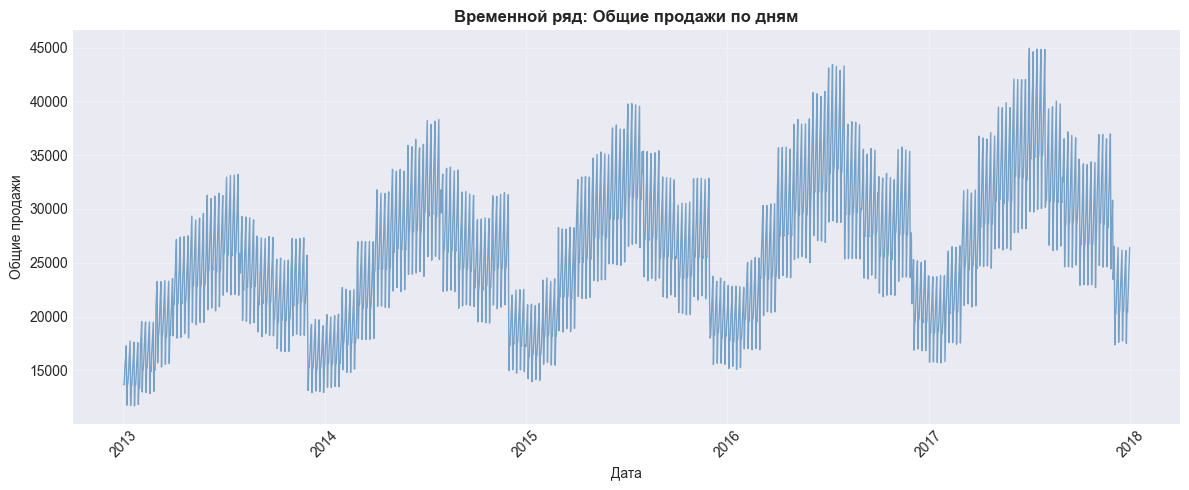


💡 Детальные визуализации (гистограмма, box plot, Q-Q plot) и анализ выбросов
   будут выполнены дальше


In [7]:
# Простая визуализация временного ряда (для общего понимания)
daily_sales = train_raw.groupby('date')['sales'].sum()

plt.figure(figsize=(12, 5))
plt.plot(daily_sales.index, daily_sales.values, linewidth=1, alpha=0.7, color='steelblue')
plt.title('Временной ряд: Общие продажи по дням', fontsize=12, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Общие продажи')
plt.tick_params(axis='x', rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Детальные визуализации (гистограмма, box plot, Q-Q plot) и анализ выбросов")
print("   будут выполнены дальше")


In [8]:
print("=" * 80)
print("💡 ВЫВОДЫ И РЕШЕНИЯ ДЛЯ ПРЕДОБРАБОТКИ")
print("=" * 80)

insights = []

# Базовые инсайты о данных
insights.append(f"1. Размерность данных: {train_raw.shape[0]:,} строк, {train_raw.shape[1]} колонок")
insights.append(f"2. Период данных: {train_raw['date'].min()} → {train_raw['date'].max()} ({(train_raw['date'].max() - train_raw['date'].min()).days} дней)")
insights.append(f"3. Количество комбинаций: {train_raw['store'].nunique()} магазинов × {train_raw['item'].nunique()} товаров = {train_raw['store'].nunique() * train_raw['item'].nunique()} временных рядов")

# Качество данных
insights.append(f"4. Качество данных: {'✅ Отличное' if train_raw.isnull().sum().sum() == 0 and train_raw.duplicated(subset=['date', 'store', 'item']).sum() == 0 else '⚠️ Требует внимания'}")

# Базовые инсайты о целевой переменной
insights.append(f"5. Целевая переменная (sales): среднее={train_raw['sales'].mean():.2f}, медиана={train_raw['sales'].median():.2f}, CV={(train_raw['sales'].std() / train_raw['sales'].mean() * 100):.2f}%")
insights.append(f"6. Нулевые продажи: {(train_raw['sales'] == 0).sum()} ({(train_raw['sales'] == 0).sum()/len(train_raw)*100:.2f}%)")

# Store и Item влияние
store_range = train_raw.groupby('store')['sales'].mean().max() - train_raw.groupby('store')['sales'].mean().min()
item_range = train_raw.groupby('item')['sales'].mean().max() - train_raw.groupby('item')['sales'].mean().min()
insights.append(f"7. Store влияние: разброс средних = {store_range:.2f} ({'сильное' if store_range > train_raw['sales'].mean() * 0.5 else 'среднее'})")
insights.append(f"8. Item влияние: разброс средних = {item_range:.2f} ({'сильное' if item_range > train_raw['sales'].mean() * 0.5 else 'среднее'})")

print("\n📊 Ключевые инсайты:")
for insight in insights:
    print(f"   {insight}")

print("\n💡 Примечание: Детальный анализ целевой переменной (распределение, выбросы, визуализации)")
print("   будет выполнен в 01_comprehensive_eda_features.ipynb после создания фичей.")

print("\n✅ РЕШЕНИЯ ДЛЯ ПРЕДОБРАБОТКИ:")
print("   1. Отрицательные sales → заменить на 0")
print("   2. Пропуски в sales → заполнить 0 (день без продаж)")
print("   3. Дубликаты → удалить (оставить первую запись)")
print("   4. Сортировка → по (store, item, date) для правильных лагов")
print("   5. Типы данных → оптимизировать (category для store/item, float32 для sales)")

print("\n✅ РЕКОМЕНДАЦИИ ДЛЯ FEATURE ENGINEERING:")
print("   1. Временные фичи: year, month, week, day_of_week, quarter")
print("   2. Lag features: lag_1, lag_7, lag_30, lag_365")
print("   3. Rolling features: rolling_mean_7, rolling_mean_30")
print("   4. Aggregated features: mean_sales_by_store, mean_sales_by_item")
print("   5. Store и Item важны - использовать в фичах")

print("\n" + "=" * 80)
print("✅ БЫСТРЫЙ EDA ЗАВЕРШЕН")
print("   Следующий шаг: Создание фичей и полный EDA")
print("=" * 80)


💡 ВЫВОДЫ И РЕШЕНИЯ ДЛЯ ПРЕДОБРАБОТКИ

📊 Ключевые инсайты:
   1. Размерность данных: 913,000 строк, 4 колонок
   2. Период данных: 2013-01-01 00:00:00 → 2017-12-31 00:00:00 (1825 дней)
   3. Количество комбинаций: 10 магазинов × 50 товаров = 500 временных рядов
   4. Качество данных: ✅ Отличное
   5. Целевая переменная (sales): среднее=52.25, медиана=47.00, CV=55.12%
   6. Нулевые продажи: 1 (0.00%)
   7. Store влияние: разброс средних = 30.67 (сильное)
   8. Item влияние: разброс средних = 69.67 (сильное)

💡 Примечание: Детальный анализ целевой переменной (распределение, выбросы, визуализации)
   будет выполнен в 01_comprehensive_eda_features.ipynb после создания фичей.

✅ РЕШЕНИЯ ДЛЯ ПРЕДОБРАБОТКИ:
   1. Отрицательные sales → заменить на 0
   2. Пропуски в sales → заполнить 0 (день без продаж)
   3. Дубликаты → удалить (оставить первую запись)
   4. Сортировка → по (store, item, date) для правильных лагов
   5. Типы данных → оптимизировать (category для store/item, float32 для sales)


---

## 📊 ЧАСТЬ 3: ДЕТАЛЬНЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

**Используются данные:** `train` (данные с фичами)

### 3.1 Распределение и выбросы


---

## ⚙️ ЧАСТЬ 3: Анализ качества данных и пропусков в фичах


In [9]:
print("=" * 80)
print("📈 АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (sales)")
print("=" * 80)

# Проверяем, что sales есть в данных
if 'sales' not in train_raw.columns:
    print("⚠️ Колонка 'sales' не найдена в данных. Возможно, это test данные.")
    print(f"   Доступные колонки: {list(train_raw.columns)[:10]}...")
else:
    print("\nБазовые статистики:")
    print(train_raw['sales'].describe())

    print(f"\nДополнительные метрики:")
    print(f"   Медиана: {train_raw['sales'].median():.2f}")
    print(f"   Коэффициент вариации: {(train_raw['sales'].std() / train_raw['sales'].mean() * 100):.2f}%")
    print(f"   Асимметрия (skewness): {train_raw['sales'].skew():.2f}")
    print(f"   Эксцесс (kurtosis): {train_raw['sales'].kurtosis():.2f}")

    # Анализ выбросов
    Q1 = train_raw['sales'].quantile(0.25)
    Q3 = train_raw['sales'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_raw[(train_raw['sales'] < lower_bound) | (train_raw['sales'] > upper_bound)]
    zero_sales = (train_raw['sales'] == 0).sum()

    print(f"\n⚠️ Выбросы (IQR метод):")
    print(f"   Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"   Количество: {len(outliers)} ({len(outliers)/len(train_raw)*100:.2f}%)")
    print(f"\n🔴 Нулевые продажи: {zero_sales} ({zero_sales/len(train_raw)*100:.2f}%)")


📈 АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (sales)

Базовые статистики:


count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

Дополнительные метрики:
   Медиана: 47.00
   Коэффициент вариации: 55.12%
   Асимметрия (skewness): 0.87
   Эксцесс (kurtosis): 0.51

⚠️ Выбросы (IQR метод):
   Границы: [-30.00, 130.00]
   Количество: 11967 (1.31%)

🔴 Нулевые продажи: 1 (0.00%)


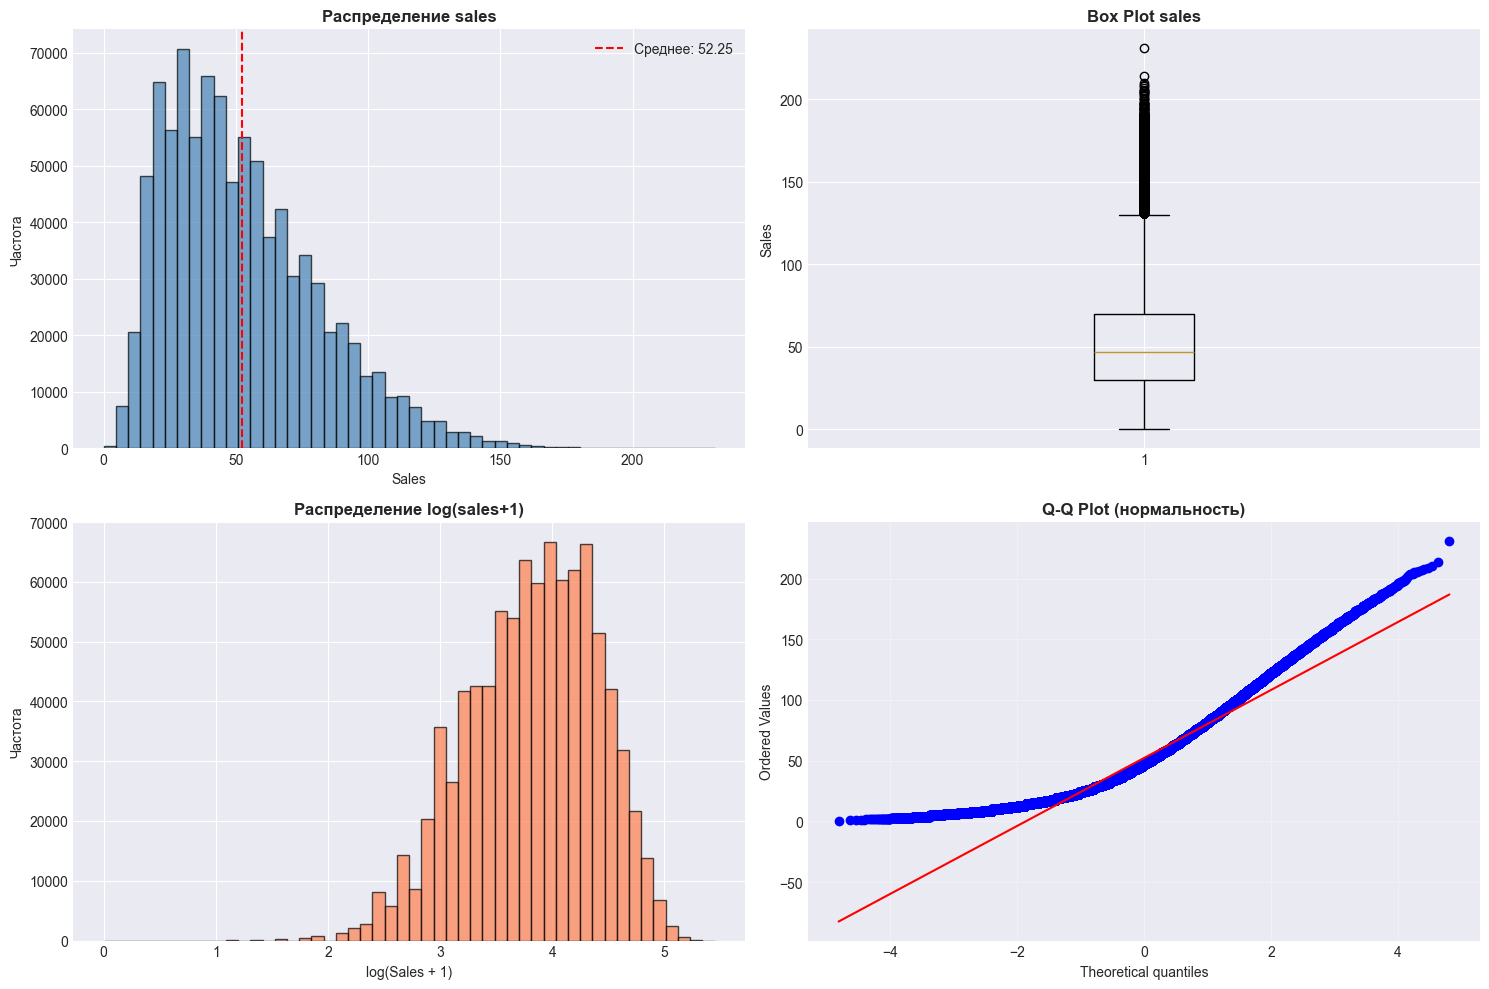

In [10]:
# Визуализация распределения (только если есть sales)
if 'sales' in train_raw.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Гистограмма
    axes[0, 0].hist(train_raw['sales'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].set_title('Распределение sales', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Sales')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].axvline(train_raw['sales'].mean(), color='red', linestyle='--', label=f'Среднее: {train_raw["sales"].mean():.2f}')
    axes[0, 0].legend()

    # Box plot
    axes[0, 1].boxplot(train_raw['sales'], vert=True)
    axes[0, 1].set_title('Box Plot sales', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Sales')

    # Логарифмическое распределение
    log_sales = np.log1p(train_raw['sales'])
    axes[1, 0].hist(log_sales, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 0].set_title('Распределение log(sales+1)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('log(Sales + 1)')
    axes[1, 0].set_ylabel('Частота')

    # Q-Q plot
    stats.probplot(train_raw['sales'], dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (нормальность)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Нет колонки 'sales' для визуализации")


### 3.2 Поиск взаимосвязей


In [11]:
# Загрузка или создание данных с фичами
# ВАЖНО: Объединяем train_raw и test_raw для создания фичей
# Это безопасно, так как все фичи используют shift() и работают только с прошлыми данными

features_file = project_root / 'data' / 'processed' / 'train_features.csv'
test_features_file = project_root / 'data' / 'processed' / 'test_features.csv'

if features_file.exists() and test_features_file.exists():
    print(f"\n📥 Загрузка существующих фичей...")
    train_full = load_dataframe(features_file, verbose=True)
    test_full = load_dataframe(test_features_file, verbose=True)
    
    # Конвертируем date в datetime (если загружено из CSV, может быть строкой)
    # Преобразуем date в datetime если нужно
    if train_full['date'].dtype == 'object' or isinstance(train_full['date'].iloc[0], str):
        train_full['date'] = pd.to_datetime(train_full['date'])
    
    if test_full is not None:
        if test_full['date'].dtype == 'object' or isinstance(test_full['date'].iloc[0], str):
            test_full['date'] = pd.to_datetime(test_full['date'])
    
    print(f"✅ Загружено train: {train_full.shape[0]:,} строк с {train_full.shape[1]} колонками")
    print(f"✅ Загружено test: {test_full.shape[0]:,} строк с {test_full.shape[1]} колонками")
    
    # ВАЖНО: Фильтруем только train часть (до 2016-09-30) для анализа корреляций
    train_end_date = pd.Timestamp('2016-09-30')
    train = train_full[train_full['date'] <= train_end_date].copy()
    print(f"\n🔍 Для анализа корреляций используем только train часть:")
    print(f"   Train: {len(train):,} записей ({train['date'].min()} → {train['date'].max()})")
    print(f"   Исключено: {len(train_full) - len(train):,} записей (validation + test)")
else:
    print("\n⚠️ train_features.csv или test_features.csv не найдены. Создаем фичи...")
    print("   ⚠️ ВАЖНО: Объединяем train_raw и test_raw для создания фичей")
    print("   ✅ БЕЗОПАСНО: Все фичи используют shift() - только прошлые данные")
    
    # Шаг 1: Подготовка данных для объединения
    train_clean = train_raw.copy()
    test_clean = test_raw.copy()
    
    # ВАЖНО: Сохраняем дату начала test ДО объединения
    # (clean_data() заполняет NaN нулями, поэтому нельзя использовать sales.isna())
    test_start_date = test_clean['date'].min()
    
    # Добавляем placeholder sales в test (нужен для группировок при создании фичей)
    # Используем 0 вместо NaN, так как clean_data() заполнит NaN нулями
    test_clean['sales'] = 0
    
    # Сохраняем id из test (нужен для submission)
    if 'id' in test_clean.columns:
        test_ids = test_clean[['id', 'date', 'store', 'item']].copy()
    
    # Шаг 2: Объединение train и test
    print("\n🔗 Объединение train и test...")
    combined = pd.concat([train_clean, test_clean], ignore_index=True)
    combined = combined.sort_values(['store', 'item', 'date']).reset_index(drop=True)
    
    print(f"   Объединенный датасет: {combined.shape[0]:,} строк")
    print(f"   Период: {combined['date'].min()} → {combined['date'].max()}")
    print(f"   Test начинается с: {test_start_date}")
    
    # Шаг 3: Создание фичей на объединенном датасете
    print("\n🔧 Создание фичей на объединенном датасете...")
    combined_features = build_all_features(
        combined,
        feature_groups=None,
        lag_periods=[1, 7, 14, 30, 90, 365],
        rolling_windows=[7, 30],
        verbose=True
    )
    
    # Шаг 4: Разделение обратно на train и test ПО ДАТАМ
    # (не по sales.isna(), так как clean_data() заполняет NaN нулями)
    print("\n📊 Разделение на train и test части...")
    
    # Разделяем по датам: test начинается с test_start_date
    train_mask = combined_features['date'] < test_start_date
    test_mask = combined_features['date'] >= test_start_date
    
    train_full = combined_features[train_mask].copy()
    test_full = combined_features[test_mask].copy()
    
    # Удаляем sales из test (если был placeholder)
    if 'sales' in test_full.columns:
        test_full = test_full.drop('sales', axis=1)
    
    # Восстанавливаем id в test (если был)
    if 'id' in test_ids.columns:
        test_full = test_full.merge(
            test_ids[['id', 'date', 'store', 'item']],
            on=['date', 'store', 'item'],
            how='left'
        )
        # Если merge создал дубликаты колонок, оставляем только нужную
        if 'id_x' in test_full.columns and 'id_y' in test_full.columns:
            test_full = test_full.drop('id_x', axis=1).rename(columns={'id_y': 'id'})
        elif 'id_x' in test_full.columns:
            test_full = test_full.rename(columns={'id_x': 'id'})
        elif 'id_y' in test_full.columns:
            test_full = test_full.rename(columns={'id_y': 'id'})
    
    print(f"   Train: {train_full.shape[0]:,} строк")
    print(f"   Test: {test_full.shape[0]:,} строк")
    
    # Проверка корректности разделения
    if len(test_full) == 0:
        print("\n⚠️ ВНИМАНИЕ: Test получился пустым!")
        print(f"   Train даты: {train_full['date'].min()} → {train_full['date'].max()}")
        print(f"   Test start date: {test_start_date}")
        print(f"   Combined даты: {combined_features['date'].min()} → {combined_features['date'].max()}")
    
    # Шаг 5: Сохранение фичей
    features_dir = project_root / 'data' / 'processed'
    features_dir.mkdir(parents=True, exist_ok=True)
    
    save_dataframe(train_full, features_file, verbose=True)
    save_dataframe(test_full, test_features_file, verbose=True)
    
    print("\n✅ Фичи сохранены:")
    print(f"   Train: {features_file}")
    print(f"   Test: {test_features_file}")
    
    # Для анализа используем только train часть (до 2016-09-30)
    train_end_date = pd.Timestamp('2016-09-30')
    train = train_full[train_full['date'] <= train_end_date].copy()
    
    print(f"\n🔍 Для анализа корреляций используем только train часть:")
    print(f"   Train: {len(train):,} записей ({train['date'].min()} → {train['date'].max()})")

feature_cols = get_feature_list(train)
print(f"\n📊 Данные с фичами (train часть): {train.shape}")
print(f"📈 Всего фичей: {len(feature_cols)}")
print("\n💡 ВАЖНО: Все корреляции и анализ фичей проводятся только на train части!")
print("   Это предотвращает data leakage при анализе корреляций с целевой переменной")
print("\n✅ Фичи для test созданы с использованием исторических данных из train")
print("   (безопасно, так как все фичи используют shift() - только прошлые данные)")



⚠️ train_features.csv или test_features.csv не найдены. Создаем фичи...
   ⚠️ ВАЖНО: Объединяем train_raw и test_raw для создания фичей
   ✅ БЕЗОПАСНО: Все фичи используют shift() - только прошлые данные

🔗 Объединение train и test...
   Объединенный датасет: 958,000 строк
   Период: 2013-01-01 00:00:00 → 2018-03-31 00:00:00
   Test начинается с: 2018-01-01 00:00:00

🔧 Создание фичей на объединенном датасете...
🧹 Очистка данных...
⚠️ Пропущенные значения:
id    913000
dtype: int64
📅 Создание временных фичей...
⏮️ Создание lag features...
📊 Создание rolling features...
📈 Создание EWMA features...
📉 Создание trend features...
🌊 Создание Fourier features...
📦 Создание aggregated features...
🔢 Создание ratio features...
📆 Создание calendar features...
🔗 Создание interaction features...
📐 Создание polynomial features...
📊 Создание seasonal decomposition features...
✅ Готово! Создано 113 колонок
   Исходных колонок: 4 (date, store, item, sales)
   Новых фичей: 109

📊 Разделение на train и t

In [12]:
# Проверка наличия целевой переменной
has_sales = 'sales' in train.columns
if not has_sales:
    print("⚠️ Колонка 'sales' не найдена. Некоторые анализы будут пропущены.")
    print(f"   Доступные колонки: {list(train.columns)[:10]}...")


In [13]:
# Анализ категориальных признаков
print("=" * 80)
print("📊 ВЛИЯНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("=" * 80)

if 'sales' in train.columns:
    # Store
    if 'store' in train.columns:
        store_impact = train.groupby('store')['sales'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
        print("\n🏪 Средние продажи по магазинам:")
        print(store_impact)
    
    # Item
    if 'item' in train.columns:
        item_impact = train.groupby('item')['sales'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
        print("\n📦 Средние продажи по товарам (топ-10):")
        print(item_impact.head(10))
    
    # Временные паттерны (используем уже созданные фичи)
    if 'month' in train.columns:
        month_impact = train.groupby('month')['sales'].agg(['mean', 'std'])
        print("\n📅 Статистика продаж по месяцам:")
        print(month_impact)
    
    if 'day_of_week' in train.columns:
        dow_impact = train.groupby('day_of_week')['sales'].agg(['mean', 'std'])
        print("\n📅 Статистика продаж по дням недели:")
        print(dow_impact)
else:
    print("⚠️ Колонка 'sales' не найдена. Анализ категориальных признаков пропущен.")
    print(f"   Доступные колонки: {list(train.columns)[:20]}...")


📊 ВЛИЯНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

🏪 Средние продажи по магазинам:
            mean        std  count
store                             
2      64.764717  32.486301  68450
8      61.962631  31.165461  68450
3      57.515587  29.023369  68450
10     56.732491  28.602438  68450
9      53.180992  26.906565  68450
4      53.048840  26.823816  68450
1      45.647465  23.209545  68450
5      38.407555  19.697491  68450
6      38.396843  19.631699  68450
7      35.124119  18.069006  68450

📦 Средние продажи по товарам (топ-10):
           mean        std  count
item                             
15    85.061943  28.587494  13690
28    84.912125  28.540152  13690
13    81.453545  27.412104  13690
18    81.404015  27.377434  13690
25    78.001755  26.462599  13690
22    77.808617  26.316463  13690
45    77.803070  26.407583  13690
38    77.773705  26.256592  13690
36    74.443245  25.233101  13690
8     74.272682  25.290546  13690

📅 Статистика продаж по месяцам:
            mean        std
mon

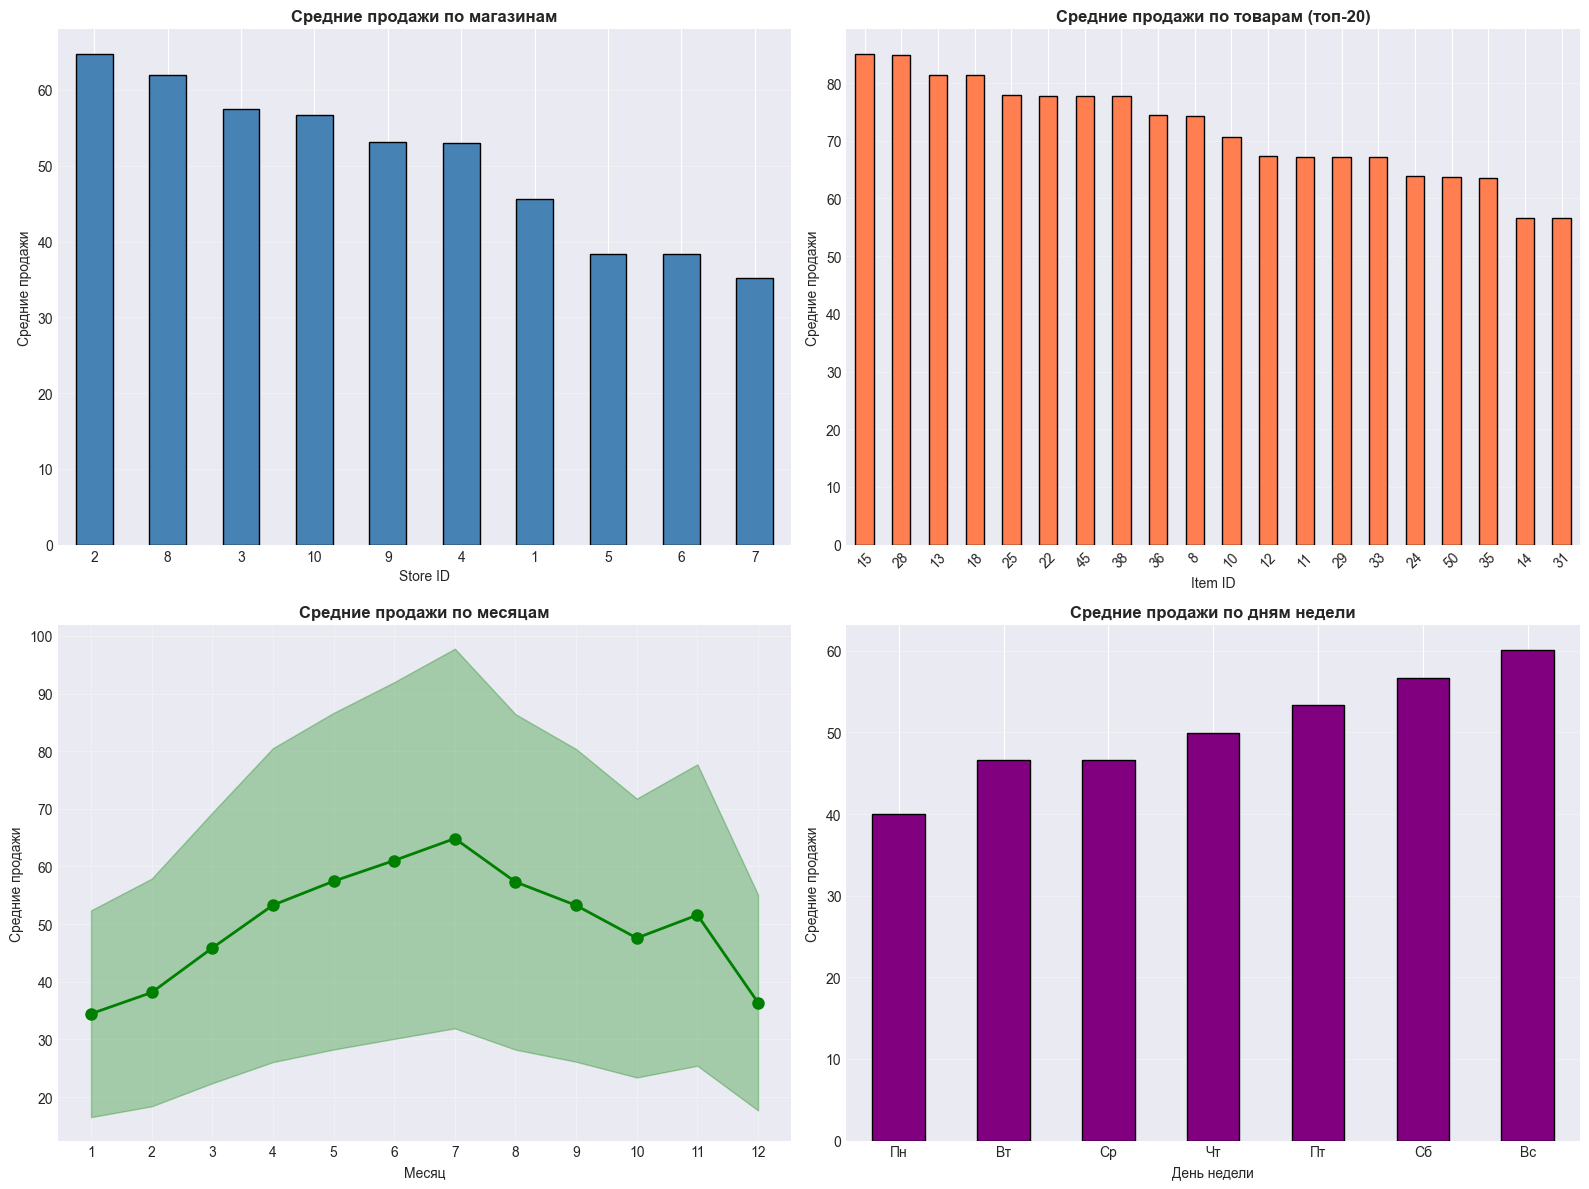

In [14]:
# Визуализация влияния категориальных признаков
if 'sales' in train.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plot_count = 0
    
    # Store
    if 'store' in train.columns:
        store_impact = train.groupby('store')['sales'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
        store_impact['mean'].plot(kind='bar', ax=axes[0, 0], color='steelblue', edgecolor='black')
        axes[0, 0].set_title('Средние продажи по магазинам', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Store ID')
        axes[0, 0].set_ylabel('Средние продажи')
        axes[0, 0].tick_params(axis='x', rotation=0)
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        plot_count += 1
    
    # Item (топ-20)
    if 'item' in train.columns:
        item_impact = train.groupby('item')['sales'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
        item_impact.head(20)['mean'].plot(kind='bar', ax=axes[0, 1], color='coral', edgecolor='black')
        axes[0, 1].set_title('Средние продажи по товарам (топ-20)', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Item ID')
        axes[0, 1].set_ylabel('Средние продажи')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3, axis='y')
        plot_count += 1
    
    # Месяц
    if 'month' in train.columns:
        month_impact = train.groupby('month')['sales'].agg(['mean', 'std'])
        month_impact['mean'].plot(kind='line', ax=axes[1, 0], marker='o', color='green', linewidth=2, markersize=8)
        axes[1, 0].fill_between(month_impact.index, 
                                month_impact['mean'] - month_impact['std'],
                                month_impact['mean'] + month_impact['std'],
                                alpha=0.3, color='green')
        axes[1, 0].set_title('Средние продажи по месяцам', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Месяц')
        axes[1, 0].set_ylabel('Средние продажи')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_xticks(range(1, 13))
        plot_count += 1
    
    # День недели
    if 'day_of_week' in train.columns:
        dow_impact = train.groupby('day_of_week')['sales'].agg(['mean', 'std'])
        dow_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
        dow_impact['mean'].plot(kind='bar', ax=axes[1, 1], color='purple', edgecolor='black')
        axes[1, 1].set_title('Средние продажи по дням недели', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('День недели')
        axes[1, 1].set_ylabel('Средние продажи')
        axes[1, 1].set_xticklabels(dow_labels, rotation=0)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        plot_count += 1
    
    # Скрываем пустые subplots
    for i in range(plot_count, 4):
        axes.flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Нет данных для визуализации (отсутствует колонка 'sales')")


---

---

## 📈 ЧАСТЬ 4: АНАЛИЗ СОЗДАННЫХ ФИЧЕЙ


### 4.1 Анализ для Feature Engineering


In [15]:
print("=" * 80)
print("🔧 АНАЛИЗ СОЗДАННЫХ ФИЧЕЙ")
print("=" * 80)

# Анализируем, какие фичи уже созданы
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()
feature_categories = {
    'Временные': [col for col in numeric_cols if col in ['year', 'month', 'week', 'day_of_week', 'day_of_month', 'day_of_year', 'quarter']],
    'Lag features': [col for col in numeric_cols if 'lag' in col.lower()],
    'Rolling features': [col for col in numeric_cols if 'rolling' in col.lower()],
    'EWMA features': [col for col in numeric_cols if 'ewma' in col.lower()],
    'Trend features': [col for col in numeric_cols if any(x in col.lower() for x in ['diff', 'pct_change'])],
    'Fourier features': [col for col in numeric_cols if any(x in col.lower() for x in ['sin', 'cos'])],
    'Aggregated features': [col for col in numeric_cols if 'mean_sales_by' in col.lower() or 'std_sales_by' in col.lower() or 'max_sales_by' in col.lower()],
    'Ratio features': [col for col in numeric_cols if 'to_' in col.lower()],
    'Encoding': [col for col in numeric_cols if 'encoded' in col.lower() or 'interaction' in col.lower()],
}

print(f"\n📊 Созданные фичи (всего {len(numeric_cols)} числовых признаков):")
for category, features in feature_categories.items():
    if features:
        print(f"\n   {category} ({len(features)} фичей):")
        print(f"      Примеры: {features[:5]}")

print("\n💡 ДОПОЛНИТЕЛЬНЫЕ ИДЕИ ДЛЯ FEATURE ENGINEERING:")
print("   - Взаимодействия: store × month, item × month, store × item")
print("   - Сезонные разложения: trend, seasonal, residual компоненты")
print("   - Полиномиальные фичи для важных признаков")
print("   - Кластеризация по паттернам продаж")


🔧 АНАЛИЗ СОЗДАННЫХ ФИЧЕЙ

📊 Созданные фичи (всего 110 числовых признаков):

   Временные (7 фичей):
      Примеры: ['year', 'month', 'week', 'day_of_week', 'day_of_month']

   Lag features (19 фичей):
      Примеры: ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_lag_90']

   Rolling features (34 фичей):
      Примеры: ['rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7', 'rolling_median_7']

   EWMA features (3 фичей):
      Примеры: ['ewma_7', 'ewma_30', 'ewma_365']

   Trend features (10 фичей):
      Примеры: ['diff_1', 'diff_7', 'pct_change_7', 'diff_30', 'pct_change_30']

   Fourier features (10 фичей):
      Примеры: ['sin_month', 'cos_month', 'sin_week', 'cos_week', 'sin_day_of_year']

   Aggregated features (7 фичей):
      Примеры: ['mean_sales_by_store_item', 'mean_sales_by_store', 'mean_sales_by_item', 'std_sales_by_store', 'std_sales_by_item']

   Ratio features (8 фичей):
      Примеры: ['days_to_month_end', 'days_to_quarter_end', 'da

---

## ⚙️ ЧАСТЬ 5: КАЧЕСТВО ДАННЫХ С ФИЧАМИ

**Используются данные:** `train` (данные с фичами)


In [16]:
print("=" * 80)
print("📊 КАЧЕСТВО ДАННЫХ С ФИЧАМИ")
print("=" * 80)

print(f"\n✅ Данные предобработаны и содержат все фичи!")
print(f"   Размерность: {train.shape}")
print(f"   Колонок: {len(train.columns)}")

# Проверка качества данных
print("\n📊 Проверка качества данных:")
print(f"   Пропуски: {train.isnull().sum().sum()} (всего)")
if train.isnull().sum().sum() > 0:
    missing_cols = train.isnull().sum()
    missing_df = missing_cols[missing_cols > 0].sort_values(ascending=False)
    print(f"   Колонки с пропусками (топ-10):")
    for col, count in missing_df.head(10).items():
        print(f"      - {col}: {count} ({count/len(train)*100:.2f}%)")
    print("\n   💡 Примечание: Пропуски в лагах (lag_365, lag_90) - ожидаемо для первых строк")
else:
    print("   ✅ Пропусков нет!")

print(f"   Дубликаты: {train.duplicated(subset=['date', 'store', 'item']).sum()}")
if 'sales' in train.columns:
    print(f"   Отрицательные sales: {(train['sales'] < 0).sum()}")

print("\n💡 Примечание: Предобработка выполнена в build_features.py")
print("   - Типы данных оптимизированы")
print("   - Данные отсортированы по (store, item, date)")
print("   - Все фичи созданы с защитой от data leakage")

# Анализ пропусков в фичах
if train.isnull().sum().sum() > 0:
    print("\n📊 АНАЛИЗ ПРОПУСКОВ В ФИЧАХ:")
    
    missing_cols = train.isnull().sum()
    missing_df = missing_cols[missing_cols > 0].sort_values(ascending=False)
    
    # Группируем по типам фичей
    lag_missing = [col for col in missing_df.index if 'lag' in col.lower()]
    rolling_missing = [col for col in missing_df.index if 'rolling' in col.lower()]
    aggregated_missing = [col for col in missing_df.index if 'mean_sales_by' in col.lower() or 'std_sales_by' in col.lower()]
    
    if lag_missing:
        print(f"\n   ⏮️ Lag features с пропусками ({len(lag_missing)}):")
        for col in lag_missing[:5]:
            pct = missing_df[col] / len(train) * 100
            print(f"      - {col}: {missing_df[col]:,} ({pct:.2f}%)")
        if len(lag_missing) > 5:
            print(f"      ... и еще {len(lag_missing) - 5} фичей")
    
    if rolling_missing:
        print(f"\n   📊 Rolling features с пропусками ({len(rolling_missing)}):")
        for col in rolling_missing[:3]:
            pct = missing_df[col] / len(train) * 100
            print(f"      - {col}: {missing_df[col]:,} ({pct:.2f}%)")
    
    if aggregated_missing:
        print(f"\n   📦 Aggregated features с пропусками ({len(aggregated_missing)}):")
        for col in aggregated_missing[:3]:
            pct = missing_df[col] / len(train) * 100
            print(f"      - {col}: {missing_df[col]:,} ({pct:.2f}%)")
    
    print("\n   💡 Рекомендации:")
    print("      - Пропуски в лагах (особенно lag_365) - ожидаемо для первых строк")
    print("      - Можно удалить строки с пропусками в критичных фичах")
    print("      - Или заполнить средним значением по store-item паре")
else:
    print("\n✅ Пропусков в фичах нет!")


📊 КАЧЕСТВО ДАННЫХ С ФИЧАМИ

✅ Данные предобработаны и содержат все фичи!
   Размерность: (684500, 113)
   Колонок: 113

📊 Проверка качества данных:


   Пропуски: 1100708 (всего)
   Колонки с пропусками (топ-10):
      - id: 684500 (100.00%)
      - sales_lag_365: 182500 (26.66%)
      - sales_lag_90: 45000 (6.57%)
      - lag_diff_90_30: 45000 (6.57%)
      - sales_lag_31: 15500 (2.26%)
      - pct_change_30: 15500 (2.26%)
      - diff_30: 15500 (2.26%)
      - sales_lag_30: 15000 (2.19%)
      - lag_diff_30_7: 15000 (2.19%)
      - sales_lag_14: 7000 (1.02%)

   💡 Примечание: Пропуски в лагах (lag_365, lag_90) - ожидаемо для первых строк
   Дубликаты: 0
   Отрицательные sales: 0

💡 Примечание: Предобработка выполнена в build_features.py
   - Типы данных оптимизированы
   - Данные отсортированы по (store, item, date)
   - Все фичи созданы с защитой от data leakage

📊 АНАЛИЗ ПРОПУСКОВ В ФИЧАХ:

   ⏮️ Lag features с пропусками (19):
      - sales_lag_365: 182,500 (26.66%)
      - sales_lag_90: 45,000 (6.57%)
      - lag_diff_90_30: 45,000 (6.57%)
      - sales_lag_31: 15,500 (2.26%)
      - sales_lag_30: 15,000 (2.19%)
      ... и ещ

---

---

## 🔍 ЧАСТЬ 6: ВАЛИДАЦИЯ И АНАЛИЗ ФИЧЕЙ

В этой части мы валидируем созданные фичи, анализируем корреляции и находим избыточные фичи.


---

## 📊 ЧАСТЬ 6.1: КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ


📊 ТОП-ФИЧИ ПО КОРРЕЛЯЦИИ С SALES

Топ-30 фичей по корреляции с sales (Pearson):
                     feature  correlation
                 sales_lag_7     0.927806
          seasonal_component     0.924846
              rolling_mean_7     0.923506
                sales_lag_14     0.920719
                    trend_30     0.920091
               rolling_q75_7     0.919506
               rolling_q25_7     0.918156
            rolling_median_7     0.918066
            sales_lag_7_sqrt     0.916407
                     ewma_30     0.916188
                      ewma_7     0.916083
             rolling_mean_30     0.915210
              rolling_q75_30     0.912338
               rolling_max_7     0.912046
     lag_7_x_store_item_mean     0.911770
           rolling_median_30     0.911593
              rolling_q25_30     0.910550
         rolling_mean_7_sqrt     0.910377
      rolling_mean_7_x_lag_7     0.909973
sales_lag_7_x_rolling_mean_7     0.909973
          rolling_q75_7_sqrt     0.905

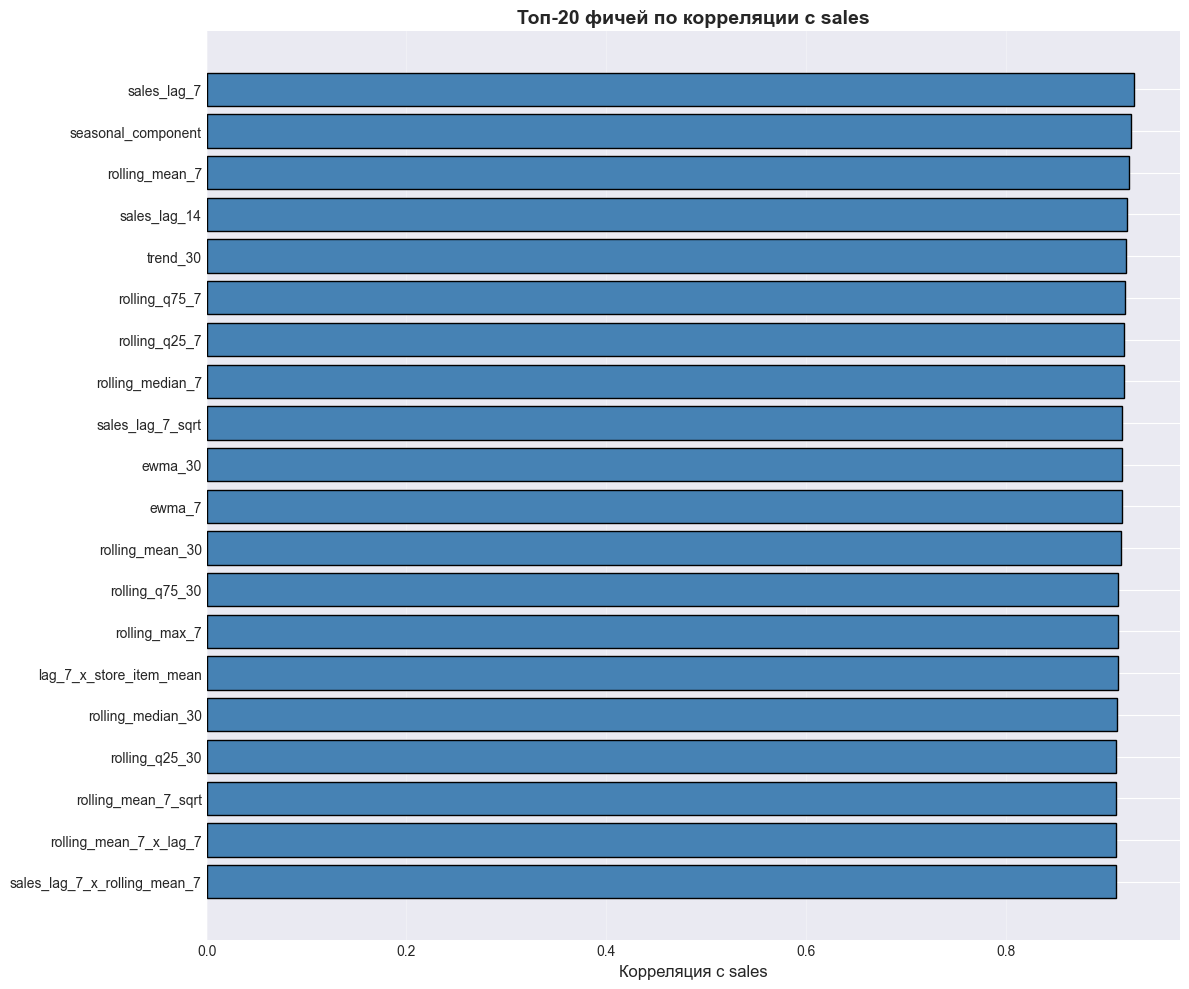


💡 Инсайты:
   - Максимальная корреляция: 0.9278
   - Средняя корреляция (топ-30): 0.9104
   - Фичей с корреляцией > 0.5: 30
   - Фичей с корреляцией > 0.7: 30


In [17]:
if 'sales' in train.columns:
    print("=" * 80)
    print("📊 ТОП-ФИЧИ ПО КОРРЕЛЯЦИИ С SALES")
    print("=" * 80)
    
    # Получаем топ-30 фичей по корреляции
    top_features = get_feature_correlations_with_target(
        train, target='sales', top_n=30, method='pearson'
    )
    
    print(f"\nТоп-30 фичей по корреляции с sales (Pearson):")
    print(top_features.to_string(index=False))
    
    # Визуализация
    plt.figure(figsize=(12, 10))
    top_20 = top_features.head(20)
    plt.barh(range(len(top_20)), top_20['correlation'].values, color='steelblue', edgecolor='black')
    plt.yticks(range(len(top_20)), top_20['feature'].values)
    plt.xlabel('Корреляция с sales', fontsize=12)
    plt.title('Топ-20 фичей по корреляции с sales', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 Инсайты:")
    print(f"   - Максимальная корреляция: {top_features['correlation'].max():.4f}")
    print(f"   - Средняя корреляция (топ-30): {top_features['correlation'].mean():.4f}")
    print(f"   - Фичей с корреляцией > 0.5: {(top_features['correlation'] > 0.5).sum()}")
    print(f"   - Фичей с корреляцией > 0.7: {(top_features['correlation'] > 0.7).sum()}")
else:
    print("⚠️ Нет колонки 'sales' для анализа корреляций")


---

## 🔗 ЧАСТЬ 6.2: КОРРЕЛЯЦИИ МЕЖДУ ФИЧАМИ


🔗 АНАЛИЗ КОРРЕЛЯЦИЙ МЕЖДУ ФИЧАМИ

⚠️ Найдено 266 пар фичей с корреляцией > 0.95:
                   feature_1              feature_2  correlation
               sin_half_year          cos_half_year     1.000000
                   half_year          sin_half_year     1.000000
                   half_year          cos_half_year     1.000000
sales_lag_7_x_rolling_mean_7 rolling_mean_7_x_lag_7     1.000000
                 day_of_year       days_to_year_end     0.999993
             rolling_mean_30                ewma_30     0.998953
             rolling_mean_30      rolling_median_30     0.997780
             rolling_mean_30         rolling_q75_30     0.997160
              rolling_q75_30                ewma_30     0.996327
           rolling_median_30                ewma_30     0.996301
                       month       days_to_year_end     0.996296
                       month            day_of_year     0.996287
              rolling_mean_7          rolling_q75_7     0.995924
         

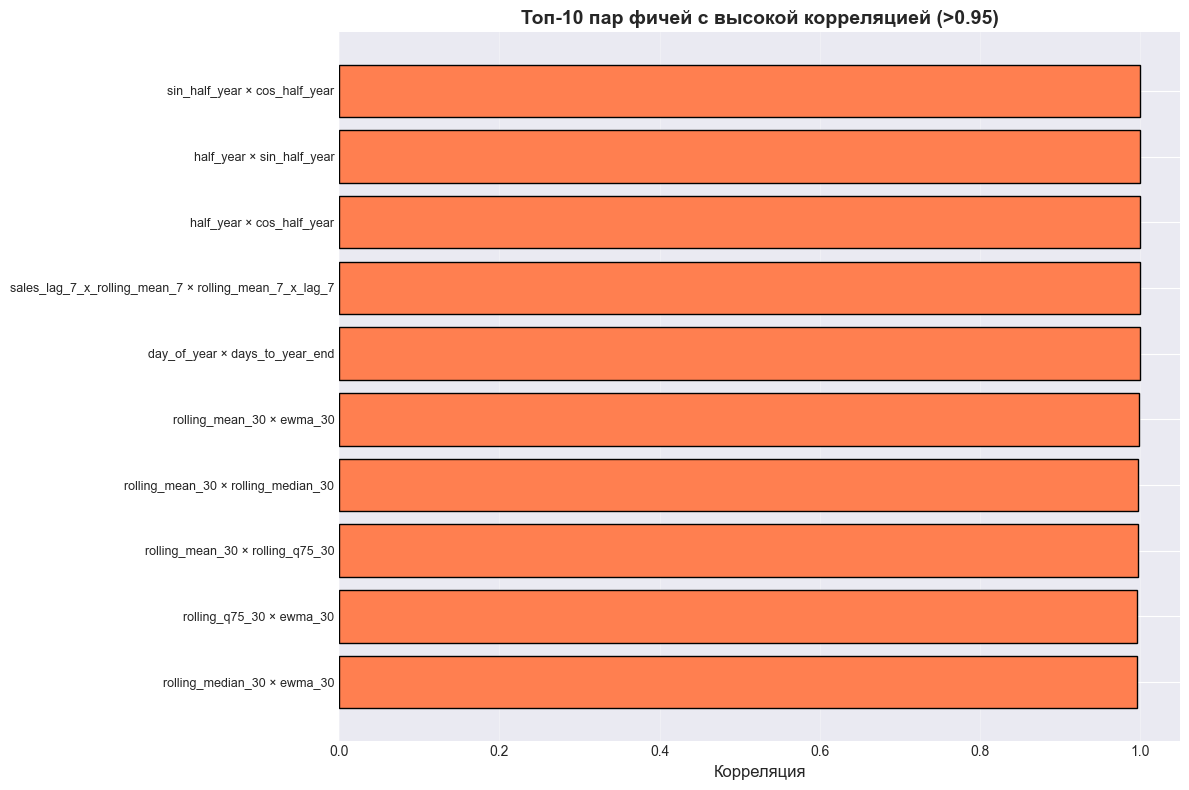


--------------------------------------------------------------------------------
Анализ с порогом 0.90:
   Найдено 625 пар фичей с корреляцией > 0.90
   Топ-5 пар:
                   feature_1              feature_2  correlation
               sin_half_year          cos_half_year     1.000000
                   half_year          sin_half_year     1.000000
                   half_year          cos_half_year     1.000000
sales_lag_7_x_rolling_mean_7 rolling_mean_7_x_lag_7     1.000000
                 day_of_year       days_to_year_end     0.999993


In [18]:
print("=" * 80)
print("🔗 АНАЛИЗ КОРРЕЛЯЦИЙ МЕЖДУ ФИЧАМИ")
print("=" * 80)

# Анализ высоких корреляций (порог 0.95)
high_corr = analyze_correlations(
    train, target='sales', threshold=0.95, method='pearson'
)

if not high_corr.empty:
    print(f"\n⚠️ Найдено {len(high_corr)} пар фичей с корреляцией > 0.95:")
    print(high_corr.head(20).to_string(index=False))
    
    # Визуализация топ-10 пар
    if len(high_corr) > 0:
        plt.figure(figsize=(12, 8))
        top_10 = high_corr.head(10)
        y_pos = np.arange(len(top_10))
        plt.barh(y_pos, top_10['correlation'].values, color='coral', edgecolor='black')
        plt.yticks(y_pos, [f"{row['feature_1']} × {row['feature_2']}" 
                           for _, row in top_10.iterrows()], fontsize=9)
        plt.xlabel('Корреляция', fontsize=12)
        plt.title('Топ-10 пар фичей с высокой корреляцией (>0.95)', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
else:
    print("\n✅ Нет пар фичей с очень высокой корреляцией (>0.95)")

# Анализ с более низким порогом (0.9)
print("\n" + "-" * 80)
print("Анализ с порогом 0.90:")
medium_corr = analyze_correlations(
    train, target='sales', threshold=0.90, method='pearson'
)

if not medium_corr.empty:
    print(f"   Найдено {len(medium_corr)} пар фичей с корреляцией > 0.90")
    print(f"   Топ-5 пар:")
    print(medium_corr.head(5).to_string(index=False))
else:
    print("   ✅ Нет пар фичей с корреляцией > 0.90")


### 6.2.1 Визуализация корреляционной матрицы (топ-фичи)


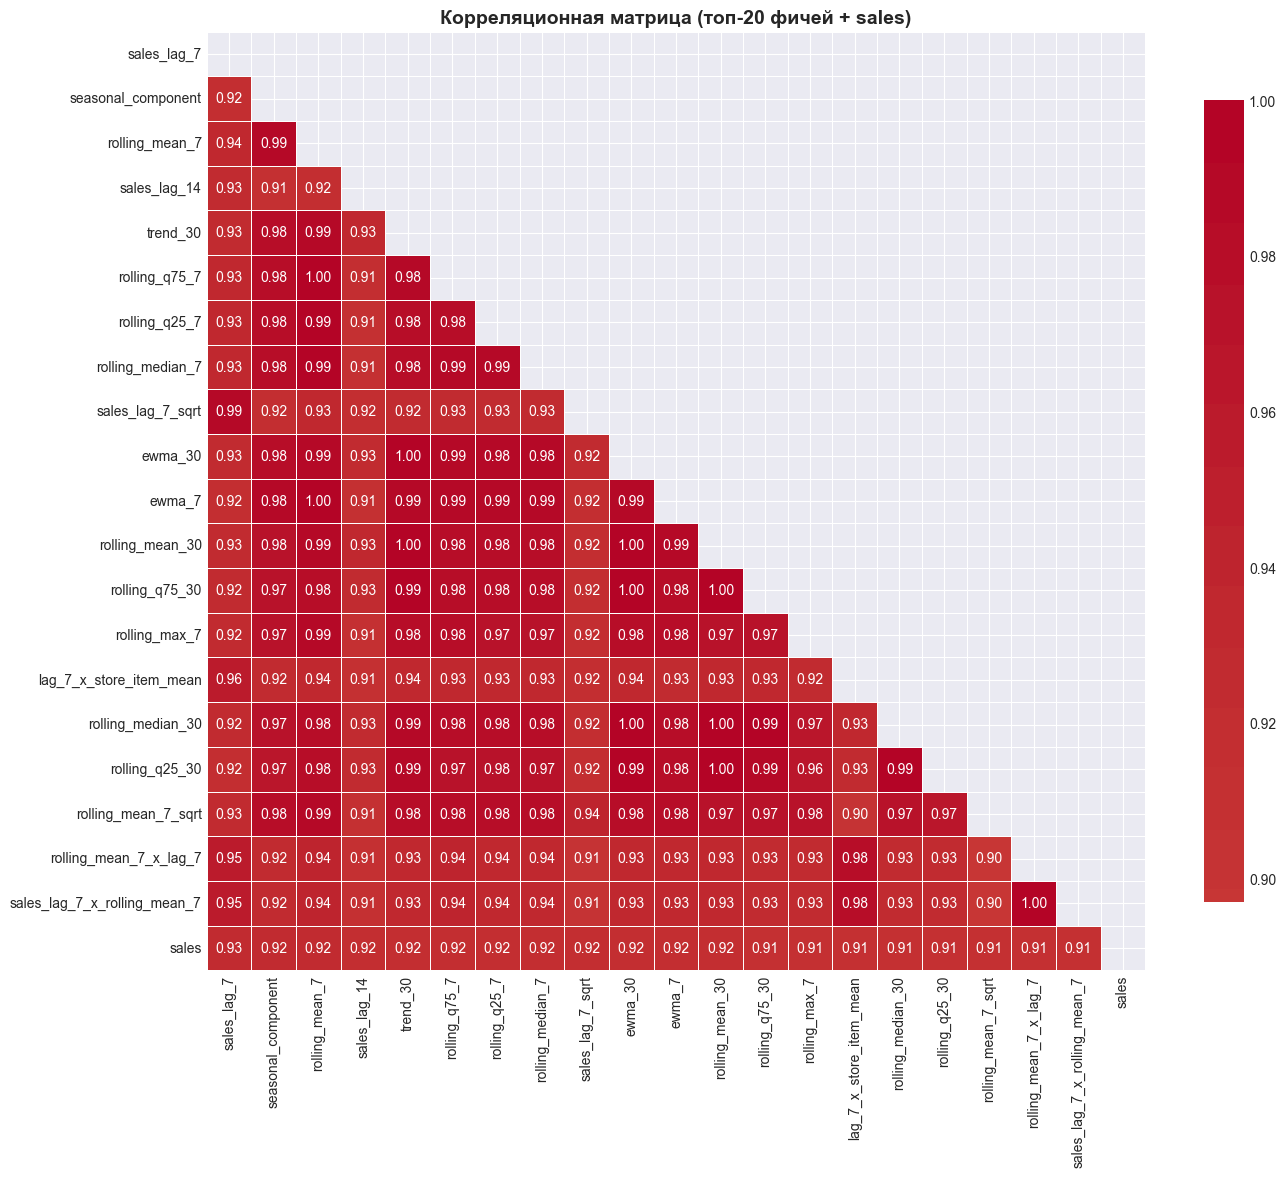


💡 Интерпретация:
   - Красный цвет: положительная корреляция
   - Синий цвет: отрицательная корреляция
   - Близкие к 1.0 значения: высокая корреляция (возможна избыточность)


In [19]:
if 'sales' in train.columns:
    # Берем топ-20 фичей по корреляции с sales
    top_20_features = get_feature_correlations_with_target(
        train, target='sales', top_n=20
    )['feature'].tolist()
    
    # Добавляем sales для полной матрицы
    cols_for_matrix = top_20_features + ['sales']
    
    # Вычисляем корреляционную матрицу
    corr_matrix = train[cols_for_matrix].corr()
    
    # Визуализация
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=True, yticklabels=True)
    plt.title('Корреляционная матрица (топ-20 фичей + sales)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Интерпретация:")
    print("   - Красный цвет: положительная корреляция")
    print("   - Синий цвет: отрицательная корреляция")
    print("   - Близкие к 1.0 значения: высокая корреляция (возможна избыточность)")


---

## 🗑️ ЧАСТЬ 6.3: ПОИСК ИЗБЫТОЧНЫХ ФИЧЕЙ


In [20]:
if 'sales' in train.columns:
    print("=" * 80)
    print("🗑️ ПОИСК ИЗБЫТОЧНЫХ ФИЧЕЙ")
    print("=" * 80)
    
    # Поиск избыточных фичей с разными порогами
    thresholds = [0.98, 0.95, 0.90]
    
    for threshold in thresholds:
        redundant = find_redundant_features(
            train, target='sales', corr_threshold=threshold, method='pearson'
        )
        
        if redundant:
            print(f"\n📊 Порог корреляции: {threshold}")
            print(f"   Найдено {len(redundant)} избыточных фичей:")
            for i, feat in enumerate(redundant[:20], 1):  # Показываем первые 20
                print(f"   {i}. {feat}")
            if len(redundant) > 20:
                print(f"   ... и еще {len(redundant) - 20} фичей")
        else:
            print(f"\n✅ Порог {threshold}: избыточных фичей не найдено")
    
    # Рекомендации
    redundant_98 = find_redundant_features(
        train, target='sales', corr_threshold=0.98, method='pearson'
    )
    
    if redundant_98:
        print(f"\n💡 РЕКОМЕНДАЦИЯ:")
        print(f"   Рекомендуется удалить {len(redundant_98)} фичей с корреляцией > 0.98")
        print(f"   Это поможет:")
        print(f"   - Ускорить обучение модели")
        print(f"   - Улучшить интерпретируемость")
        print(f"   - Снизить риск переобучения")
        print(f"\n   Список фичей для удаления:")
        print(f"   {redundant_98[:10]}")
        if len(redundant_98) > 10:
            print(f"   ... и еще {len(redundant_98) - 10} фичей")
    else:
        print("\n✅ Избыточных фичей не найдено (порог 0.98)")
else:
    print("⚠️ Нет колонки 'sales' для поиска избыточных фичей")


🗑️ ПОИСК ИЗБЫТОЧНЫХ ФИЧЕЙ

📊 Порог корреляции: 0.98
   Найдено 31 избыточных фичей:
   1. cos_half_year
   2. day_of_year
   3. days_to_month_end
   4. days_to_year_end
   5. ewma_30
   6. ewma_7
   7. max_sales_by_store
   8. mean_sales_by_store
   9. rolling_max_30
   10. rolling_max_7
   11. rolling_mean_30
   12. rolling_mean_7
   13. rolling_mean_7_sqrt
   14. rolling_mean_7_x_lag_7
   15. rolling_median_30
   16. rolling_median_7
   17. rolling_median_7_sqrt
   18. rolling_median_7_squared
   19. rolling_q25_30
   20. rolling_q25_7
   ... и еще 11 фичей

📊 Порог корреляции: 0.95
   Найдено 47 избыточных фичей:
   1. cos_half_year
   2. cos_month
   3. day_of_year
   4. days_to_month_end
   5. days_to_year_end
   6. ewma_30
   7. ewma_365
   8. ewma_7
   9. item_dow_std
   10. lag_7_x_item_mean
   11. lag_7_x_store_item_mean
   12. max_sales_by_item
   13. max_sales_by_store
   14. mean_sales_by_item
   15. mean_sales_by_store
   16. month
   17. rolling_max_30
   18. rolling_max_

---

## 📈 ЧАСТЬ 6.4: КАТЕГОРИЗАЦИЯ ФИЧЕЙ


📈 КАТЕГОРИЗАЦИЯ ФИЧЕЙ

📊 Распределение фичей по категориям:
   Всего фичей: 109

   Временные: 28 фичей (25.7%)
      Примеры: ['year', 'month', 'week', 'day_of_week', 'day_of_month'] ...
   Lag features: 19 фичей (17.4%)
      Примеры: ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_lag_90'] ...
   Rolling features: 34 фичей (31.2%)
      Примеры: ['rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7', 'rolling_median_7'] ...
   EWMA features: 3 фичей (2.8%)
      Примеры: ['ewma_7', 'ewma_30', 'ewma_365']
   Trend features: 10 фичей (9.2%)
      Примеры: ['diff_1', 'diff_7', 'pct_change_7', 'diff_30', 'pct_change_30', 'lag_diff_7_1', 'lag_diff_30_7', 'lag_diff_90_30', 'rolling_diff_mean_30_7', 'rolling_diff_std_30_7']
   Fourier features: 10 фичей (9.2%)
      Примеры: ['sin_month', 'cos_month', 'sin_week', 'cos_week', 'sin_day_of_year', 'cos_day_of_year', 'sin_quarter', 'cos_quarter', 'sin_half_year', 'cos_half_year']
   Aggregated features: 7 фич

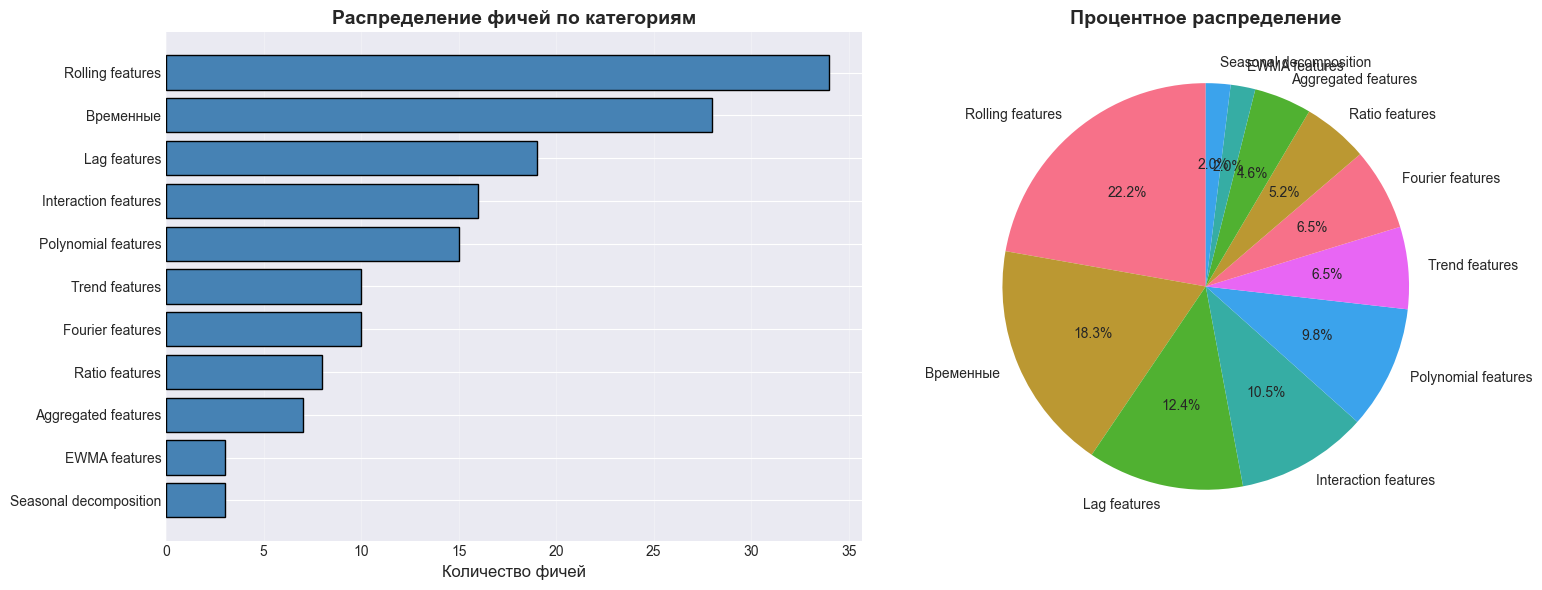

In [21]:
print("=" * 80)
print("📈 КАТЕГОРИЗАЦИЯ ФИЧЕЙ")
print("=" * 80)

# Категоризация фичей
temporal_keywords = ['year', 'month', 'week', 'day_of_week', 'day_of_month', 'day_of_year', 'quarter', 'half_year']
temporal_patterns = ['sin_', 'cos_', 'is_', 'days_to']

feature_categories = {
    'Временные': [col for col in feature_cols if col in temporal_keywords or any(pattern in col for pattern in temporal_patterns)],
    'Lag features': [col for col in feature_cols if 'lag' in col.lower()],
    'Rolling features': [col for col in feature_cols if 'rolling' in col.lower()],
    'EWMA features': [col for col in feature_cols if 'ewma' in col.lower()],
    'Trend features': [col for col in feature_cols if any(x in col.lower() for x in ['diff', 'pct_change'])],
    'Fourier features': [col for col in feature_cols if any(x in col.lower() for x in ['sin_', 'cos_'])],
    'Aggregated features': [col for col in feature_cols if 'mean_sales_by' in col.lower() or 'std_sales_by' in col.lower() or 'max_sales_by' in col.lower()],
    'Ratio features': [col for col in feature_cols if 'to_' in col.lower() or '_to_' in col.lower()],
    'Interaction features': [col for col in feature_cols if any(x in col for x in ['_month_', '_dow_', '_x_'])],
    'Polynomial features': [col for col in feature_cols if any(x in col for x in ['_squared', '_sqrt', '_x_'])],
    'Seasonal decomposition': [col for col in feature_cols if any(x in col for x in ['trend', 'seasonal', 'residual'])],
    'Encoding': [col for col in feature_cols if 'encoded' in col.lower() or 'interaction' in col.lower()],
}

print(f"\n📊 Распределение фичей по категориям:")
print(f"   Всего фичей: {len(feature_cols)}")
print()

category_stats = []
for category, features in feature_categories.items():
    if features:
        category_stats.append({
            'Категория': category,
            'Количество': len(features),
            'Процент': len(features) / len(feature_cols) * 100
        })
        print(f"   {category}: {len(features)} фичей ({len(features)/len(feature_cols)*100:.1f}%)")
        if len(features) <= 10:
            print(f"      Примеры: {features}")
        else:
            print(f"      Примеры: {features[:5]} ...")

# Визуализация
if category_stats:
    stats_df = pd.DataFrame(category_stats).sort_values('Количество', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot
    axes[0].barh(range(len(stats_df)), stats_df['Количество'].values, color='steelblue', edgecolor='black')
    axes[0].set_yticks(range(len(stats_df)))
    axes[0].set_yticklabels(stats_df['Категория'].values)
    axes[0].set_xlabel('Количество фичей', fontsize=12)
    axes[0].set_title('Распределение фичей по категориям', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Pie chart
    axes[1].pie(stats_df['Количество'].values, labels=stats_df['Категория'].values, 
                autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Процентное распределение', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


📊 АНАЛИЗ КАЧЕСТВА ФИЧЕЙ

1. ПРОПУСКИ В ФИЧАХ:
   Всего пропусков: 1,100,708
   Фичей с пропусками: 81

   Топ-10 фичей с наибольшим количеством пропусков:
          Фича  Пропусков  Процент
            id     684500   100.00
 sales_lag_365     182500    26.66
  sales_lag_90      45000     6.57
lag_diff_90_30      45000     6.57
  sales_lag_31      15500     2.26
 pct_change_30      15500     2.26
       diff_30      15500     2.26
  sales_lag_30      15000     2.19
 lag_diff_30_7      15000     2.19
  sales_lag_14       7000     1.02


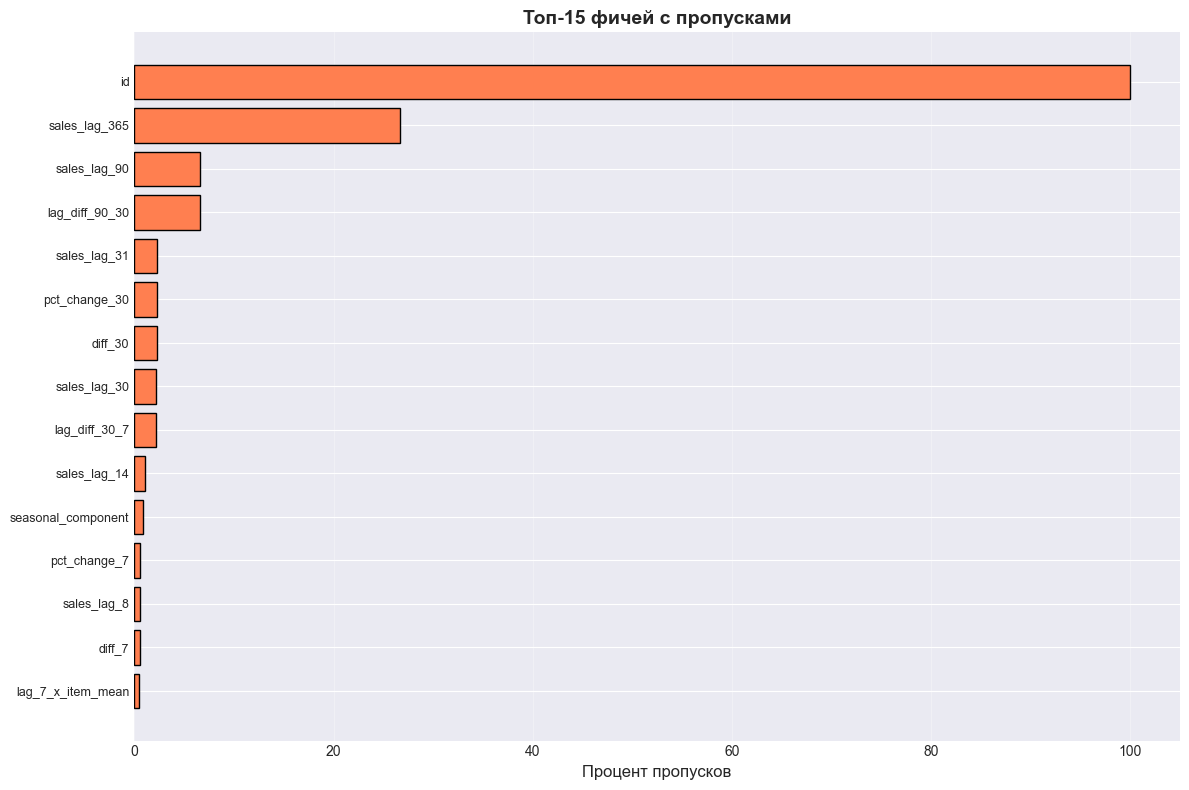


2. КОНСТАНТНЫЕ ФИЧИ:
   ⚠️ Найдено 1 константных фичей:
      - id

3. ДУБЛИКАТЫ (идентичные фичи):
   ⚠️ Найдено 4 пар с корреляцией = 1.0 (полностью идентичные)
                   feature_1              feature_2  correlation
               sin_half_year          cos_half_year          1.0
                   half_year          sin_half_year          1.0
                   half_year          cos_half_year          1.0
sales_lag_7_x_rolling_mean_7 rolling_mean_7_x_lag_7          1.0


In [22]:
print("=" * 80)
print("📊 АНАЛИЗ КАЧЕСТВА ФИЧЕЙ")
print("=" * 80)

# Проверка пропусков в фичах
print("\n1. ПРОПУСКИ В ФИЧАХ:")
missing = train[feature_cols].isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Фича': missing.index,
    'Пропусков': missing.values,
    'Процент': missing_pct.values
}).sort_values('Пропусков', ascending=False)

if missing.sum() > 0:
    print(f"   Всего пропусков: {missing.sum():,}")
    print(f"   Фичей с пропусками: {(missing > 0).sum()}")
    print(f"\n   Топ-10 фичей с наибольшим количеством пропусков:")
    print(missing_df.head(10).to_string(index=False))
    
    # Визуализация
    if (missing > 0).sum() > 0:
        top_missing = missing_df.head(15)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_missing)), top_missing['Процент'].values, color='coral', edgecolor='black')
        plt.yticks(range(len(top_missing)), top_missing['Фича'].values, fontsize=9)
        plt.xlabel('Процент пропусков', fontsize=12)
        plt.title('Топ-15 фичей с пропусками', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
else:
    print("   ✅ Пропусков нет!")

# Проверка на константные фичи
print("\n2. КОНСТАНТНЫЕ ФИЧИ:")
constant_features = []
for col in feature_cols:
    if train[col].nunique() <= 1:
        constant_features.append(col)
    elif train[col].std() == 0:
        constant_features.append(col)

if constant_features:
    print(f"   ⚠️ Найдено {len(constant_features)} константных фичей:")
    for feat in constant_features:
        print(f"      - {feat}")
else:
    print("   ✅ Константных фичей не найдено")

# Проверка на дубликаты (полностью идентичные фичи)
print("\n3. ДУБЛИКАТЫ (идентичные фичи):")
# Это сложнее проверить, но можно найти фичи с корреляцией = 1.0
if 'sales' in train.columns:
    perfect_corr = analyze_correlations(train, target='sales', threshold=1.0, method='pearson')
    if not perfect_corr.empty:
        print(f"   ⚠️ Найдено {len(perfect_corr)} пар с корреляцией = 1.0 (полностью идентичные)")
        print(perfect_corr.head(10).to_string(index=False))
    else:
        print("   ✅ Полностью идентичных фичей не найдено")


---

## 🧹 ЧАСТЬ 6.6: ОЧИСТКА ДАННЫХ ОТ ИЗБЫТОЧНЫХ ФИЧЕЙ

В этой части мы:
1. Удалим избыточные фичи (корреляция между фичами > 0.95)
2. Построим корреляционную матрицу после очистки
3. Проанализируем оставшиеся фичи


In [23]:
if 'sales' in train.columns:
    print("=" * 80)
    print("🧹 ОЧИСТКА ДАННЫХ ОТ ИЗБЫТОЧНЫХ ФИЧЕЙ")
    print("=" * 80)
    
    # Сохраняем исходные данные
    train_original = train.copy()
    feature_cols_original = feature_cols.copy()
    
    print(f"\n📊 Исходное состояние:")
    print(f"   Всего фичей: {len(feature_cols_original)}")
    print(f"   Размерность данных: {train_original.shape}")
    
    # Шаг 1: Находим избыточные фичи (корреляция между фичами > 0.95)
    print(f"\n🔍 Шаг 1: Поиск избыточных фичей (корреляция > 0.95)...")
    
    redundant_features = find_redundant_features(
        train_original, target='sales', corr_threshold=0.95, method='pearson'
    )
    
    if redundant_features:
        print(f"   ✅ Найдено {len(redundant_features)} избыточных фичей для удаления:")
        for i, feat in enumerate(redundant_features[:20], 1):
            print(f"      {i}. {feat}")
        if len(redundant_features) > 20:
            print(f"      ... и еще {len(redundant_features) - 20} фичей")
        
        # Удаляем избыточные фичи
        train_cleaned = train_original.drop(columns=redundant_features)
        
        # Обновляем список фичей
        feature_cols_cleaned = [col for col in feature_cols_original if col not in redundant_features]
        
        print(f"\n✅ После удаления избыточных фичей:")
        print(f"   Удалено фичей: {len(redundant_features)}")
        print(f"   Осталось фичей: {len(feature_cols_cleaned)}")
        print(f"   Размерность данных: {train_cleaned.shape}")
        print(f"   Сокращение: {len(redundant_features)/len(feature_cols_original)*100:.1f}%")
        
    else:
        print("   ✅ Избыточных фичей не найдено (порог 0.95)")
        train_cleaned = train_original.copy()
        feature_cols_cleaned = feature_cols_original.copy()
    
    print(f"\n💾 Данные сохранены в переменную 'train_cleaned'")
    print(f"   Используйте train_cleaned для дальнейшего анализа")
    
else:
    print("⚠️ Нет колонки 'sales' для очистки данных")
    train_cleaned = train.copy()
    feature_cols_cleaned = feature_cols.copy()


🧹 ОЧИСТКА ДАННЫХ ОТ ИЗБЫТОЧНЫХ ФИЧЕЙ

📊 Исходное состояние:
   Всего фичей: 109
   Размерность данных: (684500, 113)

🔍 Шаг 1: Поиск избыточных фичей (корреляция > 0.95)...
   ✅ Найдено 47 избыточных фичей для удаления:
      1. cos_half_year
      2. cos_month
      3. day_of_year
      4. days_to_month_end
      5. days_to_year_end
      6. ewma_30
      7. ewma_365
      8. ewma_7
      9. item_dow_std
      10. lag_7_x_item_mean
      11. lag_7_x_store_item_mean
      12. max_sales_by_item
      13. max_sales_by_store
      14. mean_sales_by_item
      15. mean_sales_by_store
      16. month
      17. rolling_max_30
      18. rolling_max_7
      19. rolling_mean_30
      20. rolling_mean_7
      ... и еще 27 фичей

✅ После удаления избыточных фичей:
   Удалено фичей: 47
   Осталось фичей: 62
   Размерность данных: (684500, 66)
   Сокращение: 43.1%

💾 Данные сохранены в переменную 'train_cleaned'
   Используйте train_cleaned для дальнейшего анализа


### 6.6.1 Корреляционная матрица после очистки


📊 КОРРЕЛЯЦИОННАЯ МАТРИЦА ПОСЛЕ ОЧИСТКИ


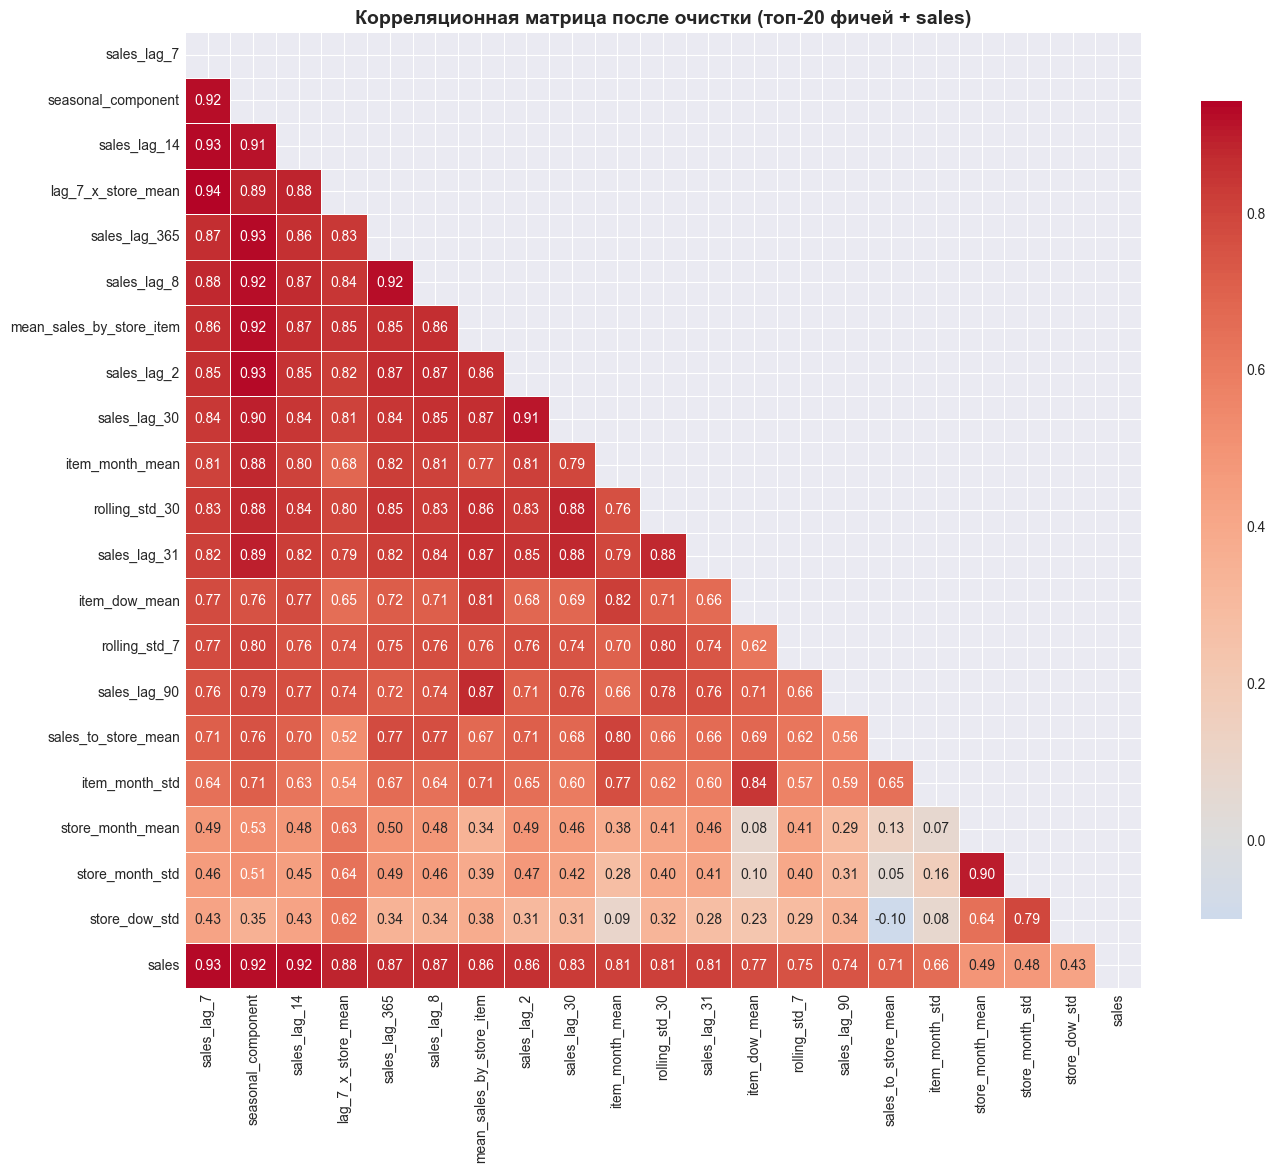


📊 Анализ корреляций после очистки:
   ✅ Нет пар фичей с корреляцией > 0.95

📈 Сравнение до и после очистки:
   До очистки: 266 пар с корреляцией > 0.95
   После очистки: 0 пар с корреляцией > 0.95
   Сокращение: 100.0%


In [24]:
if 'sales' in train_cleaned.columns and len(feature_cols_cleaned) > 0:
    print("=" * 80)
    print("📊 КОРРЕЛЯЦИОННАЯ МАТРИЦА ПОСЛЕ ОЧИСТКИ")
    print("=" * 80)
    
    # Берем топ-20 фичей по корреляции с sales из очищенных данных
    top_20_cleaned = get_feature_correlations_with_target(
        train_cleaned, target='sales', top_n=20
    )['feature'].tolist()
    
    # Добавляем sales для полной матрицы
    cols_for_matrix_cleaned = top_20_cleaned + ['sales']
    
    # Вычисляем корреляционную матрицу
    corr_matrix_cleaned = train_cleaned[cols_for_matrix_cleaned].corr()
    
    # Визуализация
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix_cleaned, dtype=bool))
    sns.heatmap(corr_matrix_cleaned, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=True, yticklabels=True)
    plt.title('Корреляционная матрица после очистки (топ-20 фичей + sales)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Проверяем, остались ли высокие корреляции
    high_corr_cleaned = analyze_correlations(
        train_cleaned, target='sales', threshold=0.95, method='pearson'
    )
    
    print(f"\n📊 Анализ корреляций после очистки:")
    if not high_corr_cleaned.empty:
        print(f"   ⚠️ Осталось {len(high_corr_cleaned)} пар с корреляцией > 0.95")
        print(f"   Топ-5 пар:")
        print(high_corr_cleaned.head(5).to_string(index=False))
    else:
        print(f"   ✅ Нет пар фичей с корреляцией > 0.95")
    
    # Сравнение с исходными данными
    if 'train_original' in locals():
        high_corr_original = analyze_correlations(
            train_original, target='sales', threshold=0.95, method='pearson'
        )
        print(f"\n📈 Сравнение до и после очистки:")
        print(f"   До очистки: {len(high_corr_original)} пар с корреляцией > 0.95")
        print(f"   После очистки: {len(high_corr_cleaned)} пар с корреляцией > 0.95")
        if len(high_corr_original) > 0:
            reduction = (1 - len(high_corr_cleaned) / len(high_corr_original)) * 100
            print(f"   Сокращение: {reduction:.1f}%")
else:
    print("⚠️ Нет данных для анализа корреляционной матрицы")


### 6.6.2 Анализ оставшихся фичей


📈 АНАЛИЗ ОСТАВШИХСЯ ФИЧЕЙ

1. ТОП-30 ФИЧЕЙ ПО КОРРЕЛЯЦИИ С SALES (после очистки):
                 feature  correlation
             sales_lag_7     0.927806
      seasonal_component     0.924846
            sales_lag_14     0.920719
      lag_7_x_store_mean     0.884534
           sales_lag_365     0.872566
             sales_lag_8     0.869316
mean_sales_by_store_item     0.862111
             sales_lag_2     0.857005
            sales_lag_30     0.827919
         item_month_mean     0.812123
          rolling_std_30     0.811648
            sales_lag_31     0.808420
           item_dow_mean     0.773094
           rolling_std_7     0.752391
            sales_lag_90     0.744297
     sales_to_store_mean     0.713469
          item_month_std     0.655183
        store_month_mean     0.491521
         store_month_std     0.476175
           store_dow_std     0.426883
      sales_to_item_mean     0.419711
      std_sales_by_store     0.363023
         cos_day_of_year     0.317644
      

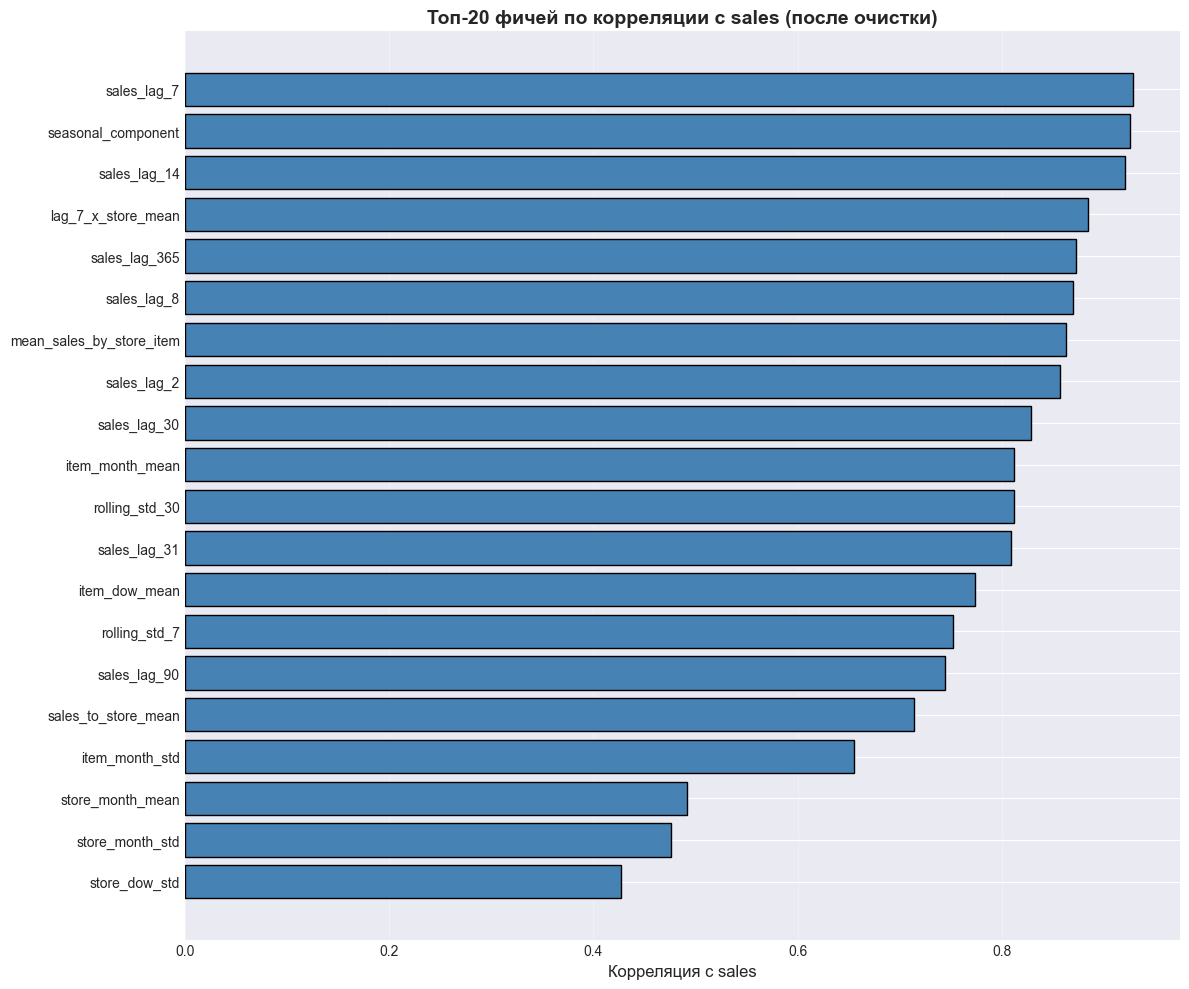


📊 Статистики корреляций (после очистки):
   Максимальная корреляция: 0.9278
   Средняя корреляция (топ-30): 0.6018
   Медианная корреляция (топ-30): 0.7289
   Фичей с корреляцией > 0.5: 17
   Фичей с корреляцией > 0.7: 16
   Фичей с корреляцией > 0.9: 3

2. КАТЕГОРИЗАЦИЯ ОСТАВШИХСЯ ФИЧЕЙ:
   Всего фичей: 62

   Временные: 19 фичей (30.6%)
   Lag features: 12 фичей (19.4%)
   Rolling features: 12 фичей (19.4%)
   Trend features: 10 фичей (16.1%)
   Fourier features: 6 фичей (9.7%)
   Aggregated features: 2 фичей (3.2%)
   Ratio features: 6 фичей (9.7%)
   Interaction features: 9 фичей (14.5%)
   Polynomial features: 1 фичей (1.6%)
   Seasonal decomposition: 2 фичей (3.2%)


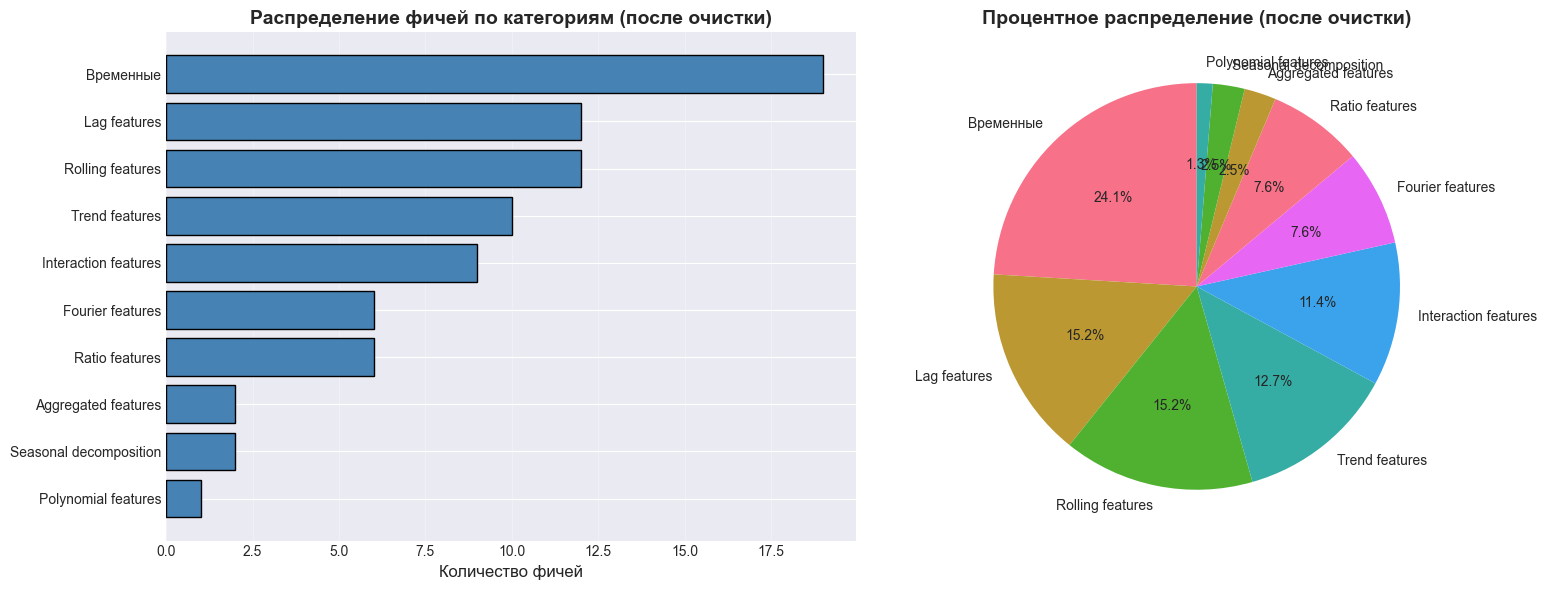


3. СРАВНЕНИЕ ДО И ПОСЛЕ ОЧИСТКИ:
   Исходное количество фичей: 109
   После очистки: 62
   Удалено: 47 фичей
   Сокращение: 43.1%

   Топ-фичи:
   Средняя корреляция (до): 0.9104
   Средняя корреляция (после): 0.6018

   Топ-10 фичей:
   Общих в топ-10 (до и после): 3
   Удалено из топ-10: 7
   Удаленные топ-фичи: ['rolling_mean_7', 'rolling_q25_7', 'rolling_median_7', 'rolling_q75_7', 'ewma_30', 'trend_30', 'sales_lag_7_sqrt']

💾 Очищенные данные сохранены в переменную 'train_cleaned'
   Используйте train_cleaned для обучения модели


In [25]:
if 'sales' in train_cleaned.columns and len(feature_cols_cleaned) > 0:
    print("=" * 80)
    print("📈 АНАЛИЗ ОСТАВШИХСЯ ФИЧЕЙ")
    print("=" * 80)
    
    # Топ-фичи по корреляции с sales после очистки
    top_features_cleaned = get_feature_correlations_with_target(
        train_cleaned, target='sales', top_n=30, method='pearson'
    )
    
    print(f"\n1. ТОП-30 ФИЧЕЙ ПО КОРРЕЛЯЦИИ С SALES (после очистки):")
    print(top_features_cleaned.to_string(index=False))
    
    # Визуализация
    plt.figure(figsize=(12, 10))
    top_20_vis = top_features_cleaned.head(20)
    plt.barh(range(len(top_20_vis)), top_20_vis['correlation'].values, 
             color='steelblue', edgecolor='black')
    plt.yticks(range(len(top_20_vis)), top_20_vis['feature'].values)
    plt.xlabel('Корреляция с sales', fontsize=12)
    plt.title('Топ-20 фичей по корреляции с sales (после очистки)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Статистики
    print(f"\n📊 Статистики корреляций (после очистки):")
    print(f"   Максимальная корреляция: {top_features_cleaned['correlation'].max():.4f}")
    print(f"   Средняя корреляция (топ-30): {top_features_cleaned['correlation'].mean():.4f}")
    print(f"   Медианная корреляция (топ-30): {top_features_cleaned['correlation'].median():.4f}")
    print(f"   Фичей с корреляцией > 0.5: {(top_features_cleaned['correlation'] > 0.5).sum()}")
    print(f"   Фичей с корреляцией > 0.7: {(top_features_cleaned['correlation'] > 0.7).sum()}")
    print(f"   Фичей с корреляцией > 0.9: {(top_features_cleaned['correlation'] > 0.9).sum()}")
    
    # Категоризация оставшихся фичей
    print(f"\n2. КАТЕГОРИЗАЦИЯ ОСТАВШИХСЯ ФИЧЕЙ:")
    temporal_keywords = ['year', 'month', 'week', 'day_of_week', 'day_of_month', 'day_of_year', 'quarter', 'half_year']
    temporal_patterns = ['sin_', 'cos_', 'is_', 'days_to']
    
    feature_categories_cleaned = {
        'Временные': [col for col in feature_cols_cleaned if col in temporal_keywords or any(pattern in col for pattern in temporal_patterns)],
        'Lag features': [col for col in feature_cols_cleaned if 'lag' in col.lower()],
        'Rolling features': [col for col in feature_cols_cleaned if 'rolling' in col.lower()],
        'EWMA features': [col for col in feature_cols_cleaned if 'ewma' in col.lower()],
        'Trend features': [col for col in feature_cols_cleaned if any(x in col.lower() for x in ['diff', 'pct_change'])],
        'Fourier features': [col for col in feature_cols_cleaned if any(x in col.lower() for x in ['sin_', 'cos_'])],
        'Aggregated features': [col for col in feature_cols_cleaned if 'mean_sales_by' in col.lower() or 'std_sales_by' in col.lower() or 'max_sales_by' in col.lower()],
        'Ratio features': [col for col in feature_cols_cleaned if 'to_' in col.lower() or '_to_' in col.lower()],
        'Interaction features': [col for col in feature_cols_cleaned if any(x in col for x in ['_month_', '_dow_', '_x_'])],
        'Polynomial features': [col for col in feature_cols_cleaned if any(x in col for x in ['_squared', '_sqrt', '_x_'])],
        'Seasonal decomposition': [col for col in feature_cols_cleaned if any(x in col for x in ['trend', 'seasonal', 'residual'])],
        'Encoding': [col for col in feature_cols_cleaned if 'encoded' in col.lower() or 'interaction' in col.lower()],
    }
    
    print(f"   Всего фичей: {len(feature_cols_cleaned)}")
    print()
    category_stats_cleaned = []
    for category, features in feature_categories_cleaned.items():
        if features:
            category_stats_cleaned.append({
                'Категория': category,
                'Количество': len(features),
                'Процент': len(features) / len(feature_cols_cleaned) * 100
            })
            print(f"   {category}: {len(features)} фичей ({len(features)/len(feature_cols_cleaned)*100:.1f}%)")
    
    # Визуализация распределения
    if category_stats_cleaned:
        stats_df_cleaned = pd.DataFrame(category_stats_cleaned).sort_values('Количество', ascending=False)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Bar plot
        axes[0].barh(range(len(stats_df_cleaned)), stats_df_cleaned['Количество'].values, 
                     color='steelblue', edgecolor='black')
        axes[0].set_yticks(range(len(stats_df_cleaned)))
        axes[0].set_yticklabels(stats_df_cleaned['Категория'].values)
        axes[0].set_xlabel('Количество фичей', fontsize=12)
        axes[0].set_title('Распределение фичей по категориям (после очистки)', 
                          fontsize=14, fontweight='bold')
        axes[0].invert_yaxis()
        axes[0].grid(True, alpha=0.3, axis='x')
        
        # Pie chart
        axes[1].pie(stats_df_cleaned['Количество'].values, 
                   labels=stats_df_cleaned['Категория'].values, 
                   autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Процентное распределение (после очистки)', 
                         fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Сравнение с исходными данными
    if 'train_original' in locals():
        print(f"\n3. СРАВНЕНИЕ ДО И ПОСЛЕ ОЧИСТКИ:")
        print(f"   Исходное количество фичей: {len(feature_cols_original)}")
        print(f"   После очистки: {len(feature_cols_cleaned)}")
        print(f"   Удалено: {len(feature_cols_original) - len(feature_cols_cleaned)} фичей")
        print(f"   Сокращение: {(len(feature_cols_original) - len(feature_cols_cleaned))/len(feature_cols_original)*100:.1f}%")
        
        # Сравнение топ-фичей
        top_features_original = get_feature_correlations_with_target(
            train_original, target='sales', top_n=30, method='pearson'
        )
        
        print(f"\n   Топ-фичи:")
        print(f"   Средняя корреляция (до): {top_features_original['correlation'].mean():.4f}")
        print(f"   Средняя корреляция (после): {top_features_cleaned['correlation'].mean():.4f}")
        
        # Проверяем, какие топ-фичи остались
        top_10_original = set(top_features_original.head(10)['feature'].tolist())
        top_10_cleaned = set(top_features_cleaned.head(10)['feature'].tolist())
        common_top = top_10_original.intersection(top_10_cleaned)
        
        print(f"\n   Топ-10 фичей:")
        print(f"   Общих в топ-10 (до и после): {len(common_top)}")
        print(f"   Удалено из топ-10: {len(top_10_original - top_10_cleaned)}")
        if len(top_10_original - top_10_cleaned) > 0:
            print(f"   Удаленные топ-фичи: {list(top_10_original - top_10_cleaned)}")
    
    print(f"\n💾 Очищенные данные сохранены в переменную 'train_cleaned'")
    print(f"   Используйте train_cleaned для обучения модели")
    
else:
    print("⚠️ Нет данных для анализа оставшихся фичей")


### 6.6.3 Сохранение очищенных данных (опционально)


In [26]:
# Опционально: сохранить очищенные данные
# Раскомментируйте код ниже, если хотите сохранить очищенные данные

if 'train_cleaned' in locals() and 'sales' in train_cleaned.columns:
    print("=" * 80)
    print("💾 СОХРАНЕНИЕ ОЧИЩЕННЫХ ДАННЫХ")
    print("=" * 80)
    
    # Установите SAVE_CLEANED = True для сохранения
    SAVE_CLEANED = True  # Измените на True для сохранения
    
    if SAVE_CLEANED:
        from src.data.save_data import save_dataframe
        
        # Сохраняем очищенные train данные
        output_file_cleaned = project_root / 'data' / 'processed' / 'train_features_cleaned.csv'
        save_dataframe(train_cleaned, output_file_cleaned, verbose=True)
        
        # Применяем те же изменения к test (удаляем те же фичи)
        if 'redundant_features' in locals() and redundant_features and 'test_full' in locals():
            test_cleaned = test_full.drop(columns=redundant_features, errors='ignore')
            test_output_file_cleaned = project_root / 'data' / 'processed' / 'test_features_cleaned.csv'
            save_dataframe(test_cleaned, test_output_file_cleaned, verbose=True)
            print(f"\n✅ Очищенные test данные сохранены в:")
            print(f"   {test_output_file_cleaned}")
        
        print(f"\n✅ Очищенные данные сохранены в:")
        print(f"   Train: {output_file_cleaned}")
        print(f"\n📊 Статистика:")
        print(f"   Исходных фичей: {len(feature_cols_original) if 'feature_cols_original' in locals() else len(feature_cols)}")
        print(f"   Очищенных фичей: {len(feature_cols_cleaned)}")
        print(f"   Удалено: {len(feature_cols_original) - len(feature_cols_cleaned) if 'feature_cols_original' in locals() else 0} фичей")
    else:
        print("\n⏭️ Сохранение отключено (установите SAVE_CLEANED = True для сохранения)")
        print("   Данные доступны в переменной 'train_cleaned'")
        print(f"\n   Для сохранения выполните:")
        print(f"   ```python")
        print(f"   from src.data.save_data import save_dataframe")
        print(f"   save_dataframe(train_cleaned, project_root / 'data' / 'processed' / 'train_features_cleaned.csv')")
        print(f"   ```")
else:
    print("⚠️ Нет очищенных данных для сохранения")


💾 СОХРАНЕНИЕ ОЧИЩЕННЫХ ДАННЫХ
💾 Сохранено в CSV: C:\Users\teles\ml_projects\shop_project\data\processed\train_features_cleaned.csv
   Размер: 472.31 MB, Строк: 684,500, Колонок: 66
💾 Сохранено в CSV: C:\Users\teles\ml_projects\shop_project\data\processed\test_features_cleaned.csv
   Размер: 21.07 MB, Строк: 45,000, Колонок: 65

✅ Очищенные test данные сохранены в:
   C:\Users\teles\ml_projects\shop_project\data\processed\test_features_cleaned.csv

✅ Очищенные данные сохранены в:
   Train: C:\Users\teles\ml_projects\shop_project\data\processed\train_features_cleaned.csv

📊 Статистика:
   Исходных фичей: 109
   Очищенных фичей: 62
   Удалено: 47 фичей


---

## 📝 ЗАКЛЮЧЕНИЕ

### Итоговые выводы:

Выполните все предыдущие ячейки для получения итоговых выводов.

### Следующие шаги:

1. **Удалить избыточные фичи** (если найдены в Части 6)
2. **Обучить baseline модель** со всеми фичами
3. **Проанализировать feature importance** после обучения
4. **Оптимизировать набор фичей** на основе важности
5. **Провести эксперименты** с разными наборами фичей

---

### Ключевые выводы из EDA


---

## 📚 ПРИЛОЖЕНИЕ: ДОПОЛНИТЕЛЬНАЯ АНАЛИТИКА

---

## 🤔 ЧАСТЬ 7: САМОРЕФЛЕКСИЯ И КРИТИКА


In [27]:
print("=" * 80)
print("🔍 ПРОВЕРКА НА ОШИБКИ")
print("=" * 80)

checks = [
    ("Отрицательные продажи", (train['sales'] < 0).sum() == 0 if 'sales' in train.columns else True, "✅ Исправлено"),
    ("Пропущенные значения в sales", train['sales'].isnull().sum() == 0 if 'sales' in train.columns else True, "✅ Нет пропусков"),
    ("Дубликаты", train.duplicated(subset=['date', 'store', 'item']).sum() == 0, "✅ Нет дубликатов"),
]

for check_name, condition, status in checks:
    result = status if condition else "❌ Ошибка"
    print(f"\n{result} - {check_name}")


🔍 ПРОВЕРКА НА ОШИБКИ

✅ Исправлено - Отрицательные продажи

✅ Нет пропусков - Пропущенные значения в sales

✅ Нет дубликатов - Дубликаты


### 7.2 Анализ на Data Leakage


In [28]:
print("=" * 80)
print("🚨 АНАЛИЗ НА DATA LEAKAGE")
print("=" * 80)

leakage_checks = [
    ("Заполнение пропусков", "✅ БЕЗОПАСНО", "Forward fill внутри группы использует только прошлые данные"),
    ("Обработка выбросов", "✅ БЕЗОПАСНО", "Флаг is_outlier создается на основе квантилей внутри группы"),
    ("Кодирование категорий", "✅ БЕЗОПАСНО", "Label Encoding не использует информацию о target"),
    ("Lag features", "✅ БЕЗОПАСНО", "Используют shift() - только прошлые данные"),
    ("Rolling features", "✅ БЕЗОПАСНО", "Используют shift(1) перед rolling() - только прошлые данные"),
    ("Aggregated features", "✅ БЕЗОПАСНО", "Используют shift(1) перед expanding() - только прошлые данные"),
]

for aspect, status, explanation in leakage_checks:
    print(f"\n{status} - {aspect}")
    print(f"   {explanation}")

# Проверка на data leakage между train и test
if 'train_full' in locals() and 'test_full' in locals():
    print("\n" + "-" * 80)
    print("🔍 ПРОВЕРКА ОБЪЕДИНЕНИЯ TRAIN И TEST:")
    print("-" * 80)
    
    leakage_check = validate_data_leakage(train_full, test_full, target='sales')
    for warning in leakage_check['warnings']:
        print(f"   {warning}")
    
    print("\n✅ Все фичи используют shift() - только прошлые данные")
    print("   Объединение train и test безопасно для временных рядов")
    print("   Для test строк используются только данные из train (хронологически раньше)")

print("\n" + "=" * 80)
print("✅ ВЫВОД: Все операции защищены от data leakage")
print("   Рекомендуется использовать build_features.py для создания фичей")


🚨 АНАЛИЗ НА DATA LEAKAGE

✅ БЕЗОПАСНО - Заполнение пропусков
   Forward fill внутри группы использует только прошлые данные

✅ БЕЗОПАСНО - Обработка выбросов
   Флаг is_outlier создается на основе квантилей внутри группы

✅ БЕЗОПАСНО - Кодирование категорий
   Label Encoding не использует информацию о target

✅ БЕЗОПАСНО - Lag features
   Используют shift() - только прошлые данные

✅ БЕЗОПАСНО - Rolling features
   Используют shift(1) перед rolling() - только прошлые данные

✅ БЕЗОПАСНО - Aggregated features
   Используют shift(1) перед expanding() - только прошлые данные

--------------------------------------------------------------------------------
🔍 ПРОВЕРКА ОБЪЕДИНЕНИЯ TRAIN И TEST:
--------------------------------------------------------------------------------
   ✅ Нет пересечений по датам
   ✅ Временной порядок корректен

✅ Все фичи используют shift() - только прошлые данные
   Объединение train и test безопасно для временных рядов
   Для test строк используются только данные 

### 7.3 Критика своих действий


In [29]:
print("=" * 80)
print("🤔 КРИТИКА СВОИХ ДЕЙСТВИЙ")
print("=" * 80)

print("\n📋 Допущения:")
print("   1. Нулевые продажи = день без продаж (может быть закрытие магазина)")
print("   2. Выбросы не удаляются (могут быть реальными событиями - праздники, акции)")
print("   3. Forward fill для пропусков (может быть неверно для длинных пропусков)")
print("   4. Корреляция с временными признаками может быть ложной из-за тренда")

print("\n📋 Альтернативные методы:")
print("   1. Заполнение пропусков:")
print("      - Forward fill (текущий) - просто, использует только прошлое")
print("      - Интерполяция - сложнее, но точнее")
print("   2. Обработка выбросов:")
print("      - Флаг is_outlier (текущий) - модель решает")
print("      - Каппинг - может потерять важную информацию")


🤔 КРИТИКА СВОИХ ДЕЙСТВИЙ

📋 Допущения:
   1. Нулевые продажи = день без продаж (может быть закрытие магазина)
   2. Выбросы не удаляются (могут быть реальными событиями - праздники, акции)
   3. Forward fill для пропусков (может быть неверно для длинных пропусков)
   4. Корреляция с временными признаками может быть ложной из-за тренда

📋 Альтернативные методы:
   1. Заполнение пропусков:
      - Forward fill (текущий) - просто, использует только прошлое
      - Интерполяция - сложнее, но точнее
   2. Обработка выбросов:
      - Флаг is_outlier (текущий) - модель решает
      - Каппинг - может потерять важную информацию


### 7.4 Итоговая оценка рисков


In [30]:
print("=" * 80)
print("⚠️ ИТОГОВАЯ ОЦЕНКА РИСКОВ")
print("=" * 80)

risks = [
    ("Data Leakage в агрегатах", "НИЗКИЙ", "✅ РЕШЕНО", "Использовать shift(1) перед expanding()"),
    ("Неправильная сортировка данных", "ВЫСОКИЙ", "✅ РЕШЕНО", "Сортировка в clean_data()"),
    ("Пропуски в начале временных рядов", "СРЕДНИЙ", "⚠️ ОЖИДАЕМО", "Создают NaN в лагах - ожидаемо"),
    ("Выбросы могут быть реальными событиями", "СРЕДНИЙ", "✅ РЕШЕНО", "Создан флаг is_outlier"),
    ("Ложная корреляция с временными признаками", "НИЗКИЙ", "⚠️ ВОЗМОЖНО", "Использовать детрендирование"),
]

for risk_name, level, status, solution in risks:
    print(f"\n{status} - {risk_name} ({level} уровень)")
    print(f"   Решение: {solution}")

print("\n" + "=" * 80)
print("📝 РЕКОМЕНДАЦИИ:")
print("   1. Использовать build_features.py для создания фичей")
print("   2. Использовать TimeSeriesSplit для валидации")
print("   3. Проверить влияние выбросов через флаг is_outlier")
print("=" * 80)


⚠️ ИТОГОВАЯ ОЦЕНКА РИСКОВ

✅ РЕШЕНО - Data Leakage в агрегатах (НИЗКИЙ уровень)
   Решение: Использовать shift(1) перед expanding()

✅ РЕШЕНО - Неправильная сортировка данных (ВЫСОКИЙ уровень)
   Решение: Сортировка в clean_data()

⚠️ ОЖИДАЕМО - Пропуски в начале временных рядов (СРЕДНИЙ уровень)
   Решение: Создают NaN в лагах - ожидаемо

✅ РЕШЕНО - Выбросы могут быть реальными событиями (СРЕДНИЙ уровень)
   Решение: Создан флаг is_outlier

⚠️ ВОЗМОЖНО - Ложная корреляция с временными признаками (НИЗКИЙ уровень)
   Решение: Использовать детрендирование

📝 РЕКОМЕНДАЦИИ:
   1. Использовать build_features.py для создания фичей
   2. Использовать TimeSeriesSplit для валидации
   3. Проверить влияние выбросов через флаг is_outlier


---

## 💡 ЧАСТЬ 8: РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИРОВАНИЯ


In [31]:
print("=" * 80)
print("💡 РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИРОВАНИЯ")
print("=" * 80)

recommendations = []

if 'sales' in train.columns:
    # 1. Топ-фичи для использования
    top_features = get_feature_correlations_with_target(train, target='sales', top_n=30)
    recommendations.append(f"1. Использовать топ-30 фичей по корреляции с sales")
    recommendations.append(f"   Средняя корреляция: {top_features['correlation'].mean():.4f}")
    
    # 2. Избыточные фичи
    redundant = find_redundant_features(train, target='sales', corr_threshold=0.98)
    if redundant:
        recommendations.append(f"2. Удалить {len(redundant)} избыточных фичей (корреляция > 0.98)")
        recommendations.append(f"   Это ускорит обучение и улучшит интерпретируемость")
    else:
        recommendations.append("2. Избыточных фичей не найдено (порог 0.98)")
    
    # 3. Высокие корреляции
    high_corr = analyze_correlations(train, target='sales', threshold=0.95)
    if not high_corr.empty:
        recommendations.append(f"3. Обратить внимание на {len(high_corr)} пар с корреляцией > 0.95")
        recommendations.append(f"   Рассмотреть удаление одной из пары")
    else:
        recommendations.append("3. Нет пар с очень высокой корреляцией (>0.95)")

# 4. Пропуски
missing_count = train[feature_cols].isnull().sum().sum()
if missing_count > 0:
    recommendations.append(f"4. Обработать пропуски: {missing_count:,} пропусков в фичах")
    recommendations.append(f"   Рекомендуется удалить строки с пропусками в критичных фичах")
    recommendations.append(f"   Или заполнить средним значением по store-item паре")
else:
    recommendations.append("4. ✅ Пропусков в фичах нет")

# 5. Категории фичей
recommendations.append("5. Использовать фичи из разных категорий:")
recommendations.append("   - Lag features (важны для временных рядов)")
recommendations.append("   - Rolling features (улавливают тренды)")
recommendations.append("   - Interaction features (учитывают взаимодействия)")
recommendations.append("   - Aggregated features (учитывают исторические паттерны)")

# 6. Для бустинга
recommendations.append("6. Для бустинга (XGBoost, LightGBM):")
recommendations.append("   - Можно оставить все фичи (бустинг устойчив к корреляциям)")
recommendations.append("   - Использовать регуляризацию (reg_alpha, reg_lambda)")
recommendations.append("   - Проверить feature importance после обучения")

print("\n📋 Рекомендации:")
for i, rec in enumerate(recommendations, 1):
    print(f"   {rec}")

# Создаем список фичей для удаления (если нужно)
if 'sales' in train.columns:
    redundant_features = find_redundant_features(train, target='sales', corr_threshold=0.98)
    
    if redundant_features:
        print(f"\n📝 СПИСОК ФИЧЕЙ ДЛЯ УДАЛЕНИЯ (корреляция > 0.98):")
        print(f"   Всего: {len(redundant_features)} фичей")
        print(f"\n   Код для удаления:")
        print(f"   ```python")
        print(f"   features_to_drop = {redundant_features[:20]}")
        if len(redundant_features) > 20:
            print(f"   # ... и еще {len(redundant_features) - 20} фичей")
        print(f"   train_cleaned = train.drop(columns=features_to_drop)")
        print(f"   ```")


💡 РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИРОВАНИЯ

📋 Рекомендации:
   1. Использовать топ-30 фичей по корреляции с sales
      Средняя корреляция: 0.9104
   2. Удалить 31 избыточных фичей (корреляция > 0.98)
      Это ускорит обучение и улучшит интерпретируемость
   3. Обратить внимание на 266 пар с корреляцией > 0.95
      Рассмотреть удаление одной из пары
   4. Обработать пропуски: 1,100,708 пропусков в фичах
      Рекомендуется удалить строки с пропусками в критичных фичах
      Или заполнить средним значением по store-item паре
   5. Использовать фичи из разных категорий:
      - Lag features (важны для временных рядов)
      - Rolling features (улавливают тренды)
      - Interaction features (учитывают взаимодействия)
      - Aggregated features (учитывают исторические паттерны)
   6. Для бустинга (XGBoost, LightGBM):
      - Можно оставить все фичи (бустинг устойчив к корреляциям)
      - Использовать регуляризацию (reg_alpha, reg_lambda)
      - Проверить feature importance после обучения

📝 СП

### 8.1 Демонстрация TimeSeriesSplit для валидации

Для временных рядов критически важно использовать `TimeSeriesSplit` вместо обычного `KFold`, чтобы избежать "заглядывания в будущее".

📊 ДЕМОНСТРАЦИЯ TIMESERIESSPLIT

📅 Демонстрация на 1,000 записях
   Период: 2013-01-01 00:00:00 → 2013-01-02 00:00:00

🔄 TimeSeriesSplit с 5 фолдами:

 Fold Train Start  Train End  Train Size  Val Start    Val End  Val Size
    1  2013-01-01 2013-01-01         170 2013-01-01 2013-01-01       166
    2  2013-01-01 2013-01-01         336 2013-01-01 2013-01-02       166
    3  2013-01-01 2013-01-02         502 2013-01-02 2013-01-02       166
    4  2013-01-01 2013-01-02         668 2013-01-02 2013-01-02       166
    5  2013-01-01 2013-01-02         834 2013-01-02 2013-01-02       166


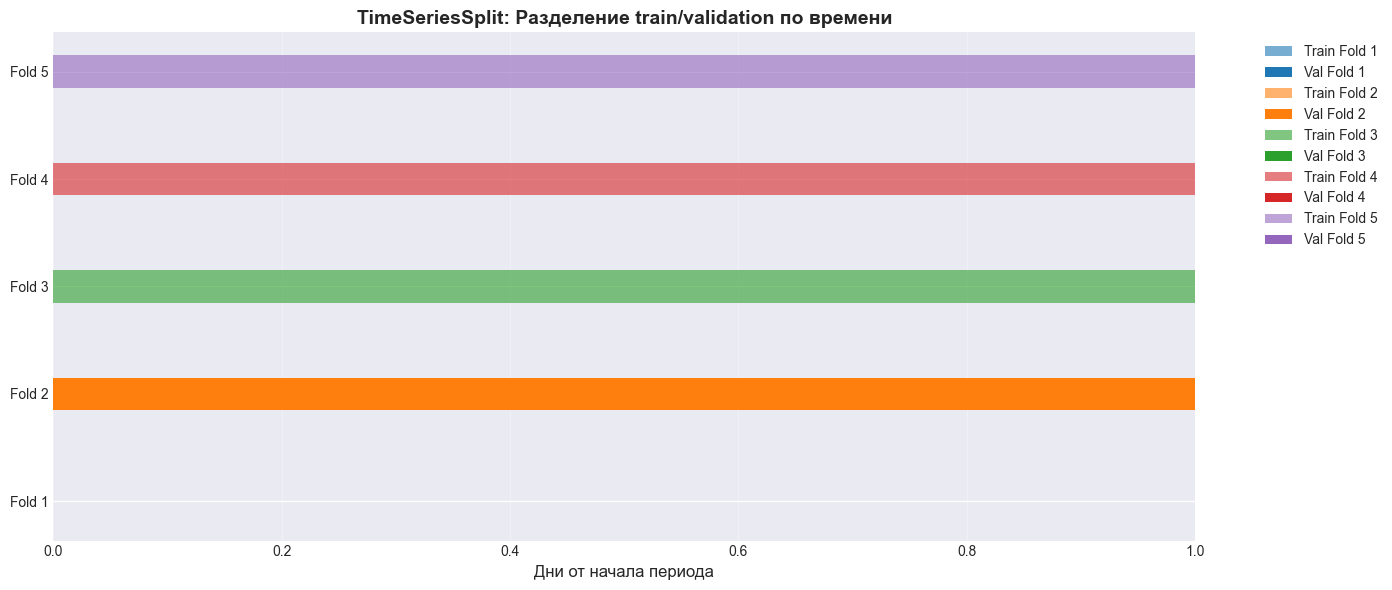


💡 Ключевые особенности TimeSeriesSplit:
   ✅ Train данные всегда предшествуют validation данным
   ✅ Каждый следующий fold добавляет данные в train
   ✅ Нет 'заглядывания в будущее' (no data leakage)
   ✅ Реалистичная оценка метрик для временных рядов

📝 Использование для моделирования:
   from sklearn.model_selection import TimeSeriesSplit
   tscv = TimeSeriesSplit(n_splits=5)
   for train_idx, val_idx in tscv.split(X_train):
       # Обучение на train_idx, валидация на val_idx


In [32]:
from sklearn.model_selection import TimeSeriesSplit

print("=" * 80)
print("📊 ДЕМОНСТРАЦИЯ TIMESERIESSPLIT")
print("=" * 80)

# Демонстрация TimeSeriesSplit
# Используем train_raw_split (до 2016-09-30) для кросс-валидации

# Создаем TimeSeriesSplit с 5 фолдами
tscv = TimeSeriesSplit(n_splits=5)

# Для демонстрации используем первые 1000 записей train_raw_split, отсортированные по дате
demo_data = train_raw_split.sort_values(['date', 'store', 'item']).head(1000)
demo_dates = demo_data['date'].unique()

print(f"\n📅 Демонстрация на {len(demo_data):,} записях")
print(f"   Период: {demo_dates.min()} → {demo_dates.max()}")
print(f"\n🔄 TimeSeriesSplit с {tscv.n_splits} фолдами:")

fold_info = []
for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(demo_data), 1):
    train_dates = demo_data.iloc[train_idx]['date']
    val_dates = demo_data.iloc[val_idx]['date']
    
    fold_info.append({
        'Fold': fold_idx,
        'Train Start': train_dates.min(),
        'Train End': train_dates.max(),
        'Train Size': len(train_idx),
        'Val Start': val_dates.min(),
        'Val End': val_dates.max(),
        'Val Size': len(val_idx)
    })

fold_df = pd.DataFrame(fold_info)
print("\n" + fold_df.to_string(index=False))

# Визуализация разделения
fig, ax = plt.subplots(figsize=(14, 6))

colors = plt.cm.tab10(range(tscv.n_splits))
y_offset = 0

for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(demo_data), 1):
    train_dates = demo_data.iloc[train_idx]['date']
    val_dates = demo_data.iloc[val_idx]['date']
    
    # Train период
    ax.barh(y_offset, (train_dates.max() - train_dates.min()).days, 
            left=(train_dates.min() - demo_dates.min()).days,
            height=0.3, color=colors[fold_idx-1], alpha=0.6, label=f'Train Fold {fold_idx}')
    
    # Validation период
    ax.barh(y_offset, (val_dates.max() - val_dates.min()).days,
            left=(val_dates.min() - demo_dates.min()).days,
            height=0.3, color=colors[fold_idx-1], alpha=1.0, label=f'Val Fold {fold_idx}')
    
    y_offset += 1

ax.set_yticks(range(tscv.n_splits))
ax.set_yticklabels([f'Fold {i+1}' for i in range(tscv.n_splits)])
ax.set_xlabel('Дни от начала периода', fontsize=12)
ax.set_title('TimeSeriesSplit: Разделение train/validation по времени', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 Ключевые особенности TimeSeriesSplit:")
print("   ✅ Train данные всегда предшествуют validation данным")
print("   ✅ Каждый следующий fold добавляет данные в train")
print("   ✅ Нет 'заглядывания в будущее' (no data leakage)")
print("   ✅ Реалистичная оценка метрик для временных рядов")

print("\n📝 Использование для моделирования:")
print("   from sklearn.model_selection import TimeSeriesSplit")
print("   tscv = TimeSeriesSplit(n_splits=5)")
print("   for train_idx, val_idx in tscv.split(X_train):")
print("       # Обучение на train_idx, валидация на val_idx")